# Annotate aggregated heart data from Pegasus pipeline

Stephen Fleming
20210121

In [1]:
# !pip install harmony-pytorch

In [1]:
import pandas as pd
import numpy as np

import scanpy as sc
import harmony
from harmony import harmonize

import glob
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sc.__version__

'1.6.1'

In [3]:
harmony.__version__

'0.1.3'

## Data: from Pegasus pipeline, already aggregated into one h5ad file

In [5]:
adata = sc.read_h5ad('/home/jupyter-user/analysis/h5ads/broad_heart_review.h5ad')

In [7]:
adata

AnnData object with n_obs × n_vars = 40880 × 30054
    obs: 'barcodes', 'n_genes', 'n_counts', 'percent_mito', 'method', 'sample', 'doublet', 'max_umis', 'study', 'disease', 'class', 'probability', 'class_2', 'probability_2'
    var: 'featureid-0', 'n_cells-0', 'percent_cells-0', 'robust-0', 'highly_variable_features-0', 'mean-0', 'var-0', 'hvf_loess-0', 'hvf_rank-0', 'bins-0', 'featureid-1', 'n_cells-1', 'percent_cells-1', 'robust-1', 'highly_variable_features-1', 'mean-1', 'var-1', 'hvf_loess-1', 'hvf_rank-1', 'bins-1', 'featureid-10', 'n_cells-10', 'percent_cells-10', 'robust-10', 'highly_variable_features-10', 'mean-10', 'var-10', 'hvf_loess-10', 'hvf_rank-10', 'bins-10', 'featureid-11', 'n_cells-11', 'percent_cells-11', 'robust-11', 'highly_variable_features-11', 'mean-11', 'var-11', 'hvf_loess-11', 'hvf_rank-11', 'bins-11', 'featureid-12', 'n_cells-12', 'percent_cells-12', 'robust-12', 'highly_variable_features-12', 'mean-12', 'var-12', 'hvf_loess-12', 'hvf_rank-12', 'bins-12', '

### UMAP

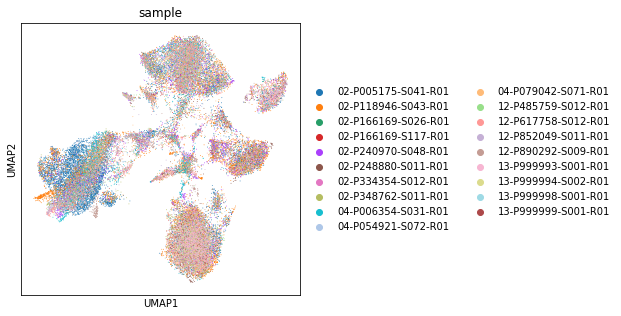

In [8]:
plt.rcParams.update({'font.size': 10})

plt.figure(figsize=(5, 5))
sc.pl.embedding(adata, basis='umap', color='sample', ax=plt.gca())

## Appending the doublet calculation (done in Pegasus separately)

In [10]:
doublet_bcs = np.genfromtxt('/home/jupyter-user/analysis/pegasus/heart_doublets.txt', 
                            dtype=str)

In [11]:
doublet_bcs

array(['02-P005175-S041-R01-GGTAATCAGTGATAGT',
       '02-P005175-S041-R01-TCAAGCACATGGCACC',
       '02-P005175-S041-R01-TGCAGTACAATGAACA', ...,
       '13-P999999-S001-R01-AGATCGTGTTTCTATC',
       '13-P999999-S001-R01-AGTGACTAGTTAGAAC',
       '13-P999999-S001-R01-TGGGAAGCATCTGGGC'], dtype='<U36')

In [12]:
len(doublet_bcs)

4131

In [13]:
np.sum([bc in adata.obs['barcodes'].values for bc in doublet_bcs])

4131

In [14]:
adata.obs.columns

Index(['barcodes', 'n_genes', 'n_counts', 'percent_mito', 'method', 'sample',
       'doublet', 'max_umis', 'study', 'disease', 'class', 'probability',
       'class_2', 'probability_2'],
      dtype='object')

In [15]:
# as saved, this is empty

adata.obs['doublet'].values.sum()

0

In [16]:
# fill it in

set_doublet_bcs = set(doublet_bcs)

adata.obs['doublet'] = np.array([bc in set_doublet_bcs for bc in adata.obs['barcodes'].values],
                                dtype=bool)
adata.obs['doublet'] = adata.obs['doublet'].astype('category')

In [17]:
adata.obs['doublet'].astype(bool).values.sum()

4131

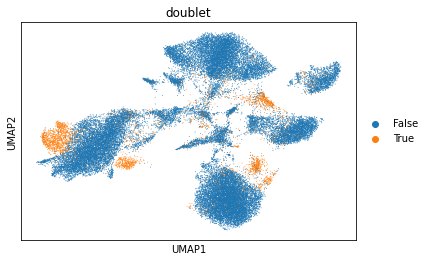

In [18]:
sc.pl.embedding(adata, basis='umap', color='doublet')

## Clustering and labeling

In [19]:
sc.tl.leiden(adata, resolution=0.5, key_added='leiden0.5')

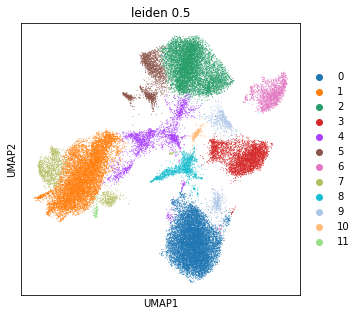

In [20]:
plt.figure(figsize=(5, 5))
sc.pl.embedding(adata, basis='umap', color='leiden0.5', ax=plt.gca(), show=False)
plt.title('leiden 0.5')
plt.show()

In [21]:
sc.tl.leiden(adata, resolution=1.5, key_added='leiden1.5')

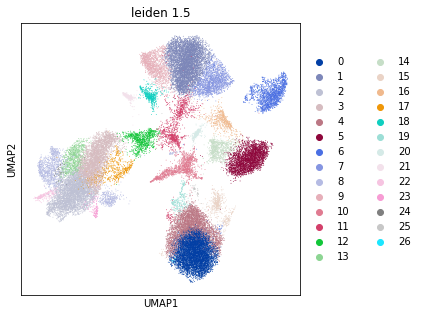

In [22]:
plt.figure(figsize=(5, 5))
sc.pl.embedding(adata, basis='umap', color='leiden1.5', ax=plt.gca(), show=False)
plt.title('leiden 1.5')
plt.show()

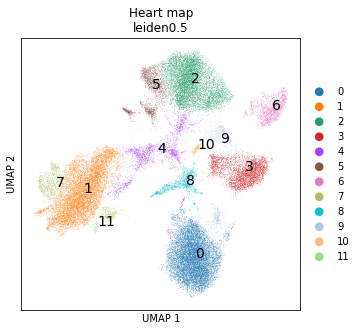

In [23]:
# umap

# show clustering with numbers

key = 'leiden0.5'

plt.figure(figsize=(5, 5))
sc.pl.scatter(adata, basis='umap', color=key, 
              ax=plt.gca(), size=1, show=False)

df = pd.DataFrame(adata.obsm['X_umap'])
df['cluster'] = adata.obs[key].values
mean_pos = df.groupby('cluster').median()

for c in mean_pos.index:
    
    plt.gca().text(mean_pos.loc[c][0] + 0.1, 
                   mean_pos.loc[c][1] + 0.01, 
                   c.split(':')[0], 
                   fontsize=14, color='black')

plt.title(f'Heart map\n{key}')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.show()

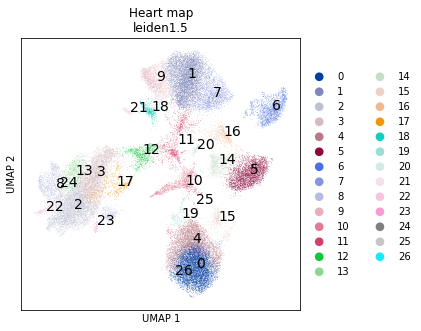

In [24]:
# umap

# show clustering with numbers

key = 'leiden1.5'

plt.figure(figsize=(5, 5))
sc.pl.scatter(adata, basis='umap', color=key, 
              ax=plt.gca(), size=1, show=False)

df = pd.DataFrame(adata.obsm['X_umap'])
df['cluster'] = adata.obs[key].values
mean_pos = df.groupby('cluster').median()

for c in mean_pos.index:
    
    plt.gca().text(mean_pos.loc[c][0] + 0.1, 
                   mean_pos.loc[c][1] + 0.01, 
                   c.split(':')[0], 
                   fontsize=14, color='black')

plt.title(f'Heart map\n{key}')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.show()

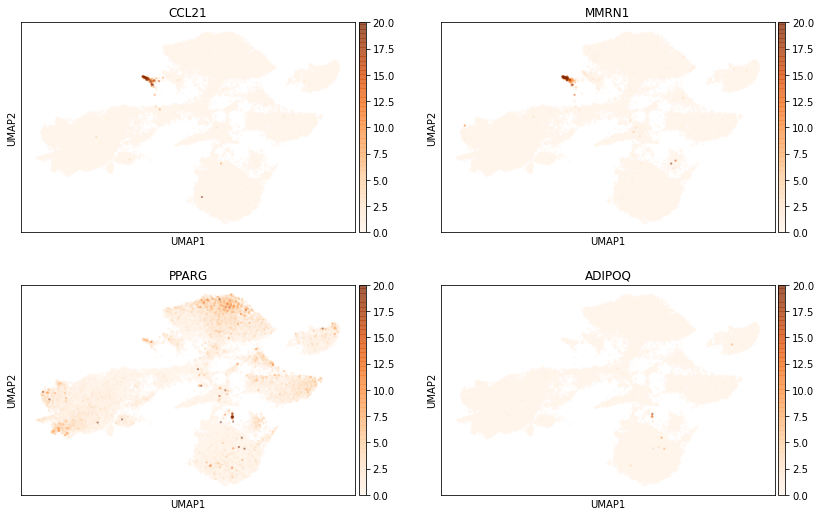

In [25]:
# check on a couple of markers I know

sc.pl.embedding(adata, basis='umap', color=['CCL21', 'MMRN1', 'PPARG', 'ADIPOQ'], 
                color_map='Oranges', ncols=2, vmax=20, size=20, alpha=0.5)

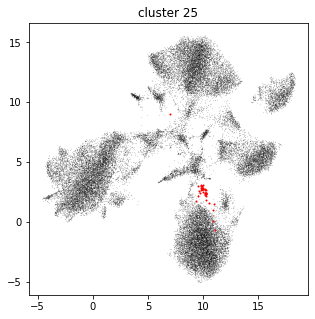

In [26]:
plt.figure(figsize=(5, 5))

plt.plot(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1], 'k.', ms=0.1)
plt.plot(adata[adata.obs['leiden1.5'] == '25'].obsm['X_umap'][:, 0], 
         adata[adata.obs['leiden1.5'] == '25'].obsm['X_umap'][:, 1], 'r.', ms=2)

plt.title('cluster 25')
plt.show()

In [27]:
# cells per cluster

adata.obs['leiden0.5'].value_counts()

0     10196
1      9231
2      7495
3      3754
4      2389
5      1968
6      1679
7      1479
8      1371
9       953
10      255
11      110
Name: leiden0.5, dtype: int64

In [28]:
# cells per cluster

adata.obs['leiden1.5'].value_counts()

0     6154
1     5506
2     4068
3     3731
4     3595
5     2891
6     1716
7     1696
8     1488
9     1432
10    1346
11    1187
12     896
13     861
14     826
15     596
16     568
17     567
18     499
19     279
20     272
21     243
22     221
23     128
24      57
25      49
26       8
Name: leiden1.5, dtype: int64

In [29]:
# cursory marker genes via wilcoxon test

key = 'leiden0.5'

sc.tl.rank_genes_groups(adata, groupby=key, method='wilcoxon',
                        key_added='rank_genes_groups_' + key)  # method='t-test_overestim_var')

/home/jupyter-user/.local/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:404: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (


In [30]:
# cursory marker genes via wilcoxon test

key = 'leiden1.5'

sc.tl.rank_genes_groups(adata, groupby=key, method='wilcoxon',
                        key_added='rank_genes_groups_' + key)  # method='t-test_overestim_var')

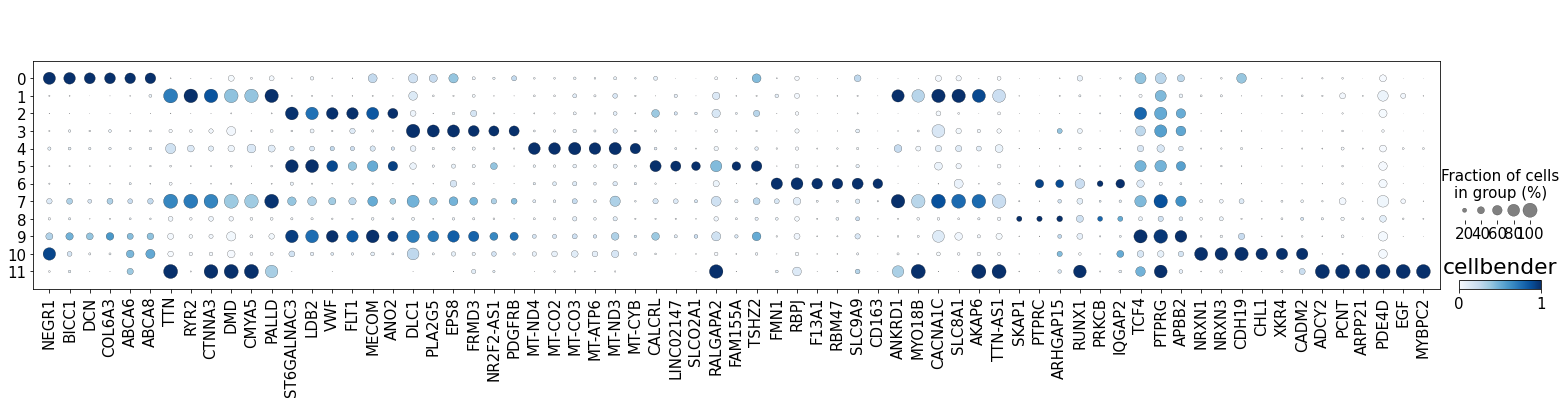

In [31]:
# plot marker genes for the outlier "clusters"
n = 6

cluster_key = 'leiden0.5'

marker_key = 'rank_genes_groups_' + cluster_key

marker_genes = np.array(adata.uns[marker_key]['names'][:(n + 5)].tolist(), 
                        dtype=str).transpose()
unique_markers = []
for k in range(marker_genes.shape[0]):
    i = 0
    for g in marker_genes[k, :]:
        if i < n and g not in unique_markers and g != 'nan':
            unique_markers.append(g)
            i += 1

plt.rcParams.update({'font.size': 18})

sc.pl.dotplot(adata, 
              var_names=unique_markers, 
              layer='counts',
              groupby=cluster_key,
#               log=True,
              standard_scale='var',
              color_map='Blues',
              smallest_dot=2,
              show=False)
plt.title('cellbender')
plt.show()

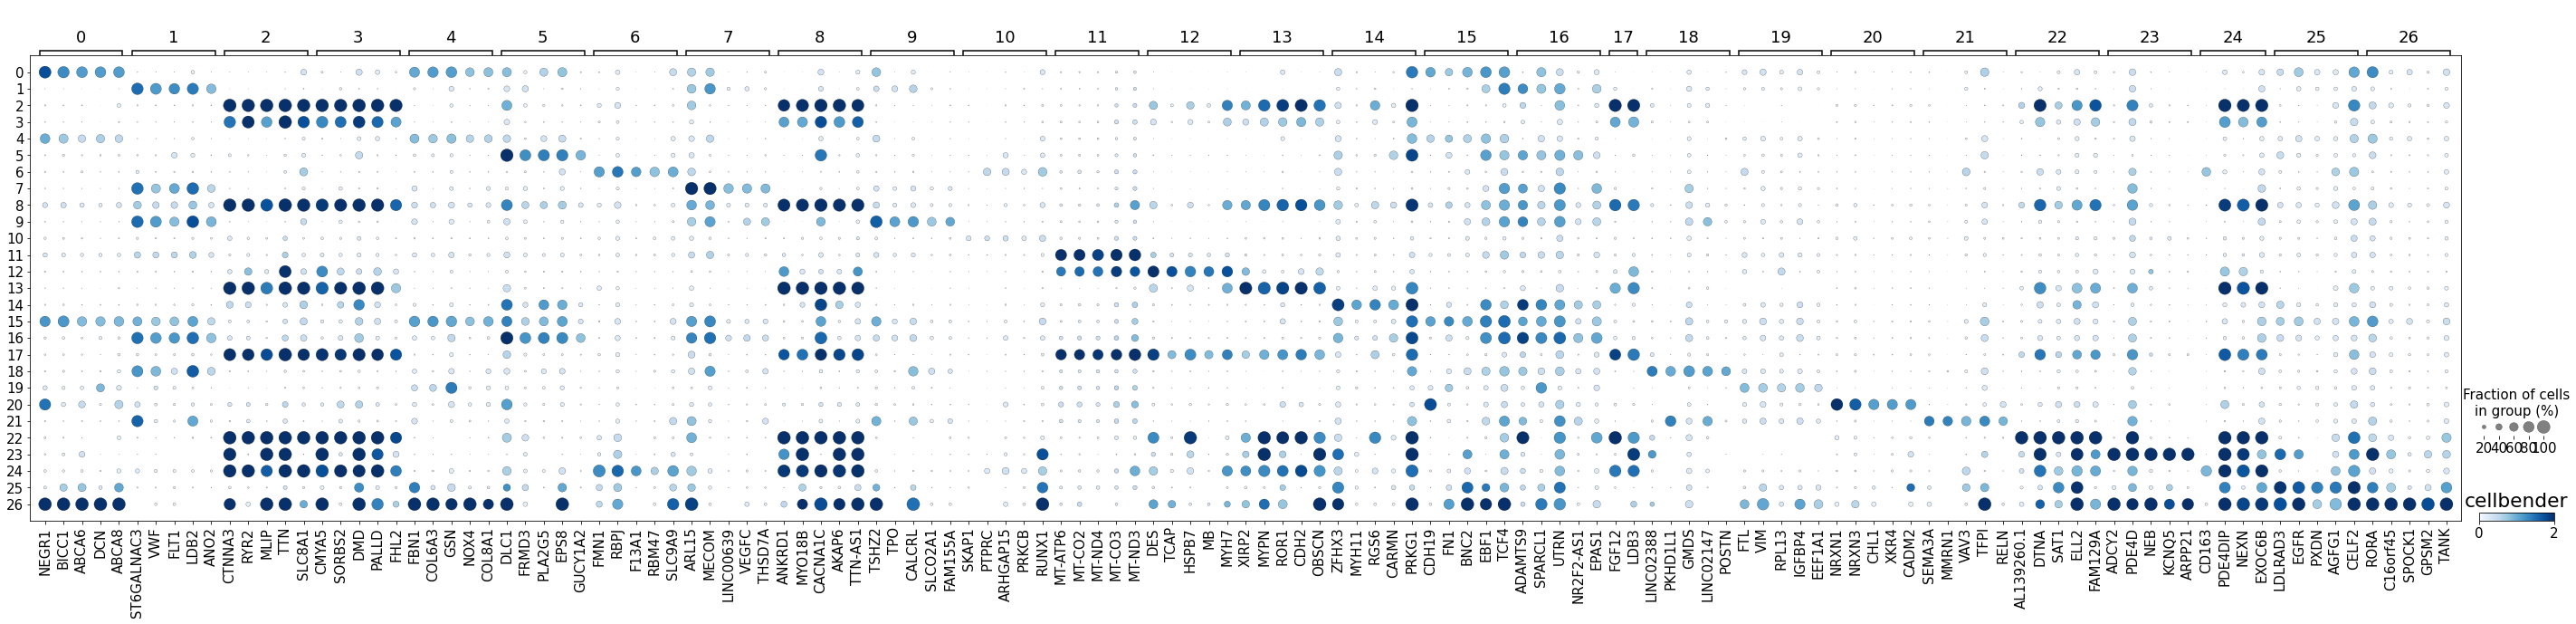

In [32]:
# plot marker genes for the outlier "clusters"
n = 5

cluster_key = 'leiden1.5'

marker_key = 'rank_genes_groups_' + cluster_key

marker_genes = np.array(adata.uns[marker_key]['names'][:(n + 10)].tolist(), 
                        dtype=str).transpose()
unique_markers = {}
for k in range(marker_genes.shape[0]):
    i = 0
    genes = []
    for g in marker_genes[k, :]:
        if ((i < n) 
            and (g not in genes) 
            and (g not in [a for it in list(unique_markers.values()) for a in it]) 
            and (g != 'nan')):
            genes.append(g)
            i += 1
    unique_markers.update({adata.obs[cluster_key].value_counts().index[k]: genes})

plt.rcParams.update({'font.size': 18})

sc.pl.dotplot(adata, 
              var_names=unique_markers, 
              layer='counts',
              groupby=cluster_key,
              log=True,
              vmax=2.,
#               standard_scale='var',
              color_map='Blues',
              smallest_dot=15,
              show=False)
plt.title('cellbender')
plt.show()

In [33]:
adata.obs.groupby('leiden1.5').agg(np.median)

n_genes  n_counts  percent_mito  max_umis  probability  \
leiden1.5                                                           
0            812.0    1150.0      0.000000      47.0     0.569335   
1            658.0     915.0      0.000000      40.0     0.708700   
2           1628.0    3603.0      0.000000     285.0     0.905062   
3            645.0    1076.0      0.000000      93.0     0.762652   
4            533.0     704.0      0.000000      29.0     0.415956   
5            656.0     944.0      0.000000      66.0     0.761063   
6            603.5     790.0      0.000000      25.0     0.593194   
7            670.0     917.0      0.000000      29.0     0.677247   
8           1843.5    3611.5      0.049383     268.0     0.785937   
9            777.0    1066.0      0.000000      37.0     0.709908   
10           526.5     693.5      0.000000      23.0     0.204865   
11           524.0     747.0      8.263836      32.0     0.417988   
12           437.0     701.5      4.856353      44.5     0.766385   
13          1099.0    2236.0      0.000000     188.0     0.858844   
14           752.5    1157.5      0.000000     105.5     0.585693   
15          1335.0    1963.5      0.000000      92.0     0.481316   
16          1232.0    1785.0      0.044020      95.5     0.609821   
17          1216.0    2469.0      3.373016     152.0     0.873562   
18           630.0     830.0      0.000000      36.0     0.462506   
19           436.0     583.0      0.000000      19.0     0.504202   
20           654.0     928.5      0.115612      30.0     0.155119   
21           731.0     993.0      0.000000      31.0     0.843942   
22          2453.0    7698.0      0.000000     764.0     0.900639   
23          2257.5    8793.0      0.000000    1330.0     0.583426   
24          1580.0    3020.0      0.064537     210.0     0.846480   
25          2307.0    5339.0      0.032000     352.0     0.482991   
26          4430.5   16799.5      0.020597    1771.0     0.701314   

           probability_2  
leiden1.5                 
0               0.100428  
1               0.026995  
2               0.019812  
3               0.030937  
4               0.099493  
5               0.073909  
6               0.036962  
7               0.021961  
8               0.065604  
9               0.037216  
10              0.082132  
11              0.062322  
12              0.028936  
13              0.033401  
14              0.197050  
15              0.145874  
16              0.178647  
17              0.022460  
18              0.057403  
19              0.072819  
20              0.084531  
21              0.843942  
22              0.023292  
23              0.087125  
24              0.034433  
25              0.059072  
26              0.073618

In [34]:
adata.obs['doublet'].value_counts()

False    36749
True      4131
Name: doublet, dtype: int64

In [35]:
adata.obs['method'].value_counts()

nuclei    40880
Name: method, dtype: int64

In [36]:
# blank template

for i in range(adata.obs['leiden1.5'].nunique()):
    print(f"'{i}': '{i}: ',")

'0': '0: ',
'1': '1: ',
'2': '2: ',
'3': '3: ',
'4': '4: ',
'5': '5: ',
'6': '6: ',
'7': '7: ',
'8': '8: ',
'9': '9: ',
'10': '10: ',
'11': '11: ',
'12': '12: ',
'13': '13: ',
'14': '14: ',
'15': '15: ',
'16': '16: ',
'17': '17: ',
'18': '18: ',
'19': '19: ',
'20': '20: ',
'21': '21: ',
'22': '22: ',
'23': '23: ',
'24': '24: ',
'25': '25: ',
'26': '26: ',


In [6]:
# stephen's manual labeling

labels = {
'0': '0: Fib 1',
'1': '1: EC 1',
'2': '2: CM 1',
'3': '3: CM 2',
'4': '4: Fib 2',
'5': '5: Pericyte',
'6': '6: Macrophage',
'7': '7: EC 2',
'8': '8: CM + EC + Pericyte',
'9': '9: EC 3',
'10': '10: T cell',
'11': '11: Mito EC',
'12': '12: Mito CM',
'13': '13: CM 3',
'14': '14: VSMC',
'15': '15: Fib + EC + Pericyte',
'16': '16: EC + Pericyte',
'17': '17: Mito CM',
'18': '18: EC (POSTN)',
'19': '19: Low count Fib',
'20': '20: Neuronal',
'21': '21: Lymph EC',
'22': '22: CM 4',
'23': '23: CM 5 (RYR2$^-$)',
'24': '24: CM + Macrophage',
'25': '25: Adipocyte',
'26': '26: Fib + CM',
}

In [7]:
adata.obs['manual_labels_leiden1.5'] = adata.obs['leiden1.5'].apply(lambda s: labels[s])

In [8]:
adata.obs['manual_labels_leiden1.5'].value_counts()

0: Fib 1                   6154
1: EC 1                    5506
2: CM 1                    4068
3: CM 2                    3731
4: Fib 2                   3595
5: Pericyte                2891
6: Macrophage              1716
7: EC 2                    1696
8: CM + EC + Pericyte      1488
9: EC 3                    1432
10: T cell                 1346
11: Mito EC                1187
12: Mito CM                 896
13: CM 3                    861
14: VSMC                    826
15: Fib + EC + Pericyte     596
16: EC + Pericyte           568
17: Mito CM                 567
18: EC (POSTN)              499
19: Low count Fib           279
20: Neuronal                272
21: Lymph EC                243
22: CM 4                    221
23: CM 5 (RYR2$^-$)         128
24: CM + Macrophage          57
25: Adipocyte                49
26: Fib + CM                  8
Name: manual_labels_leiden1.5, dtype: int64

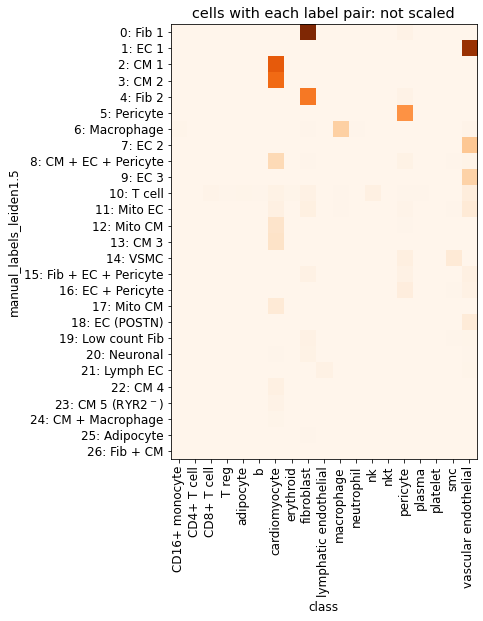

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log2


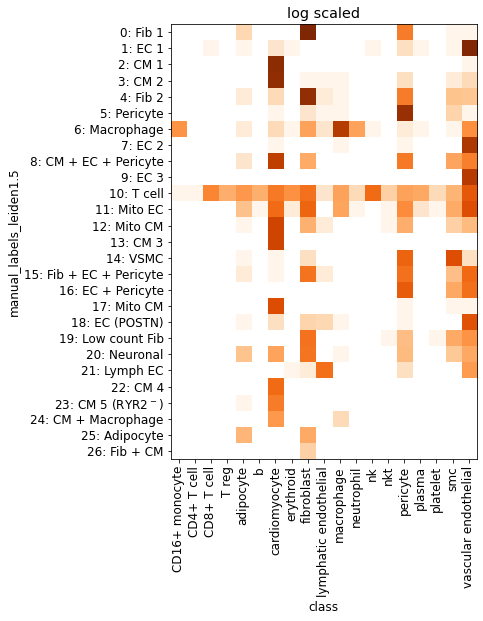

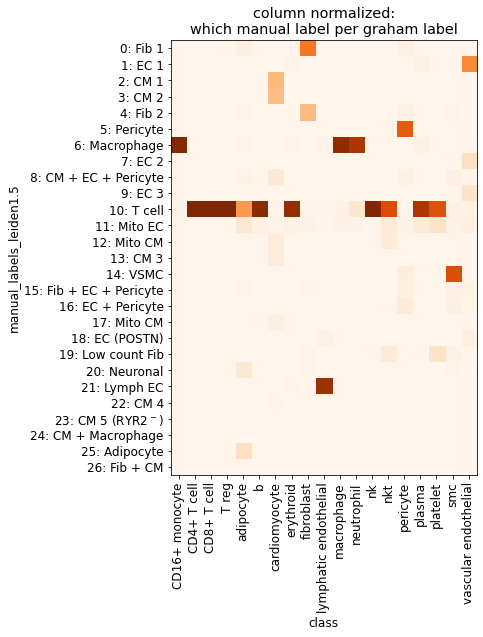

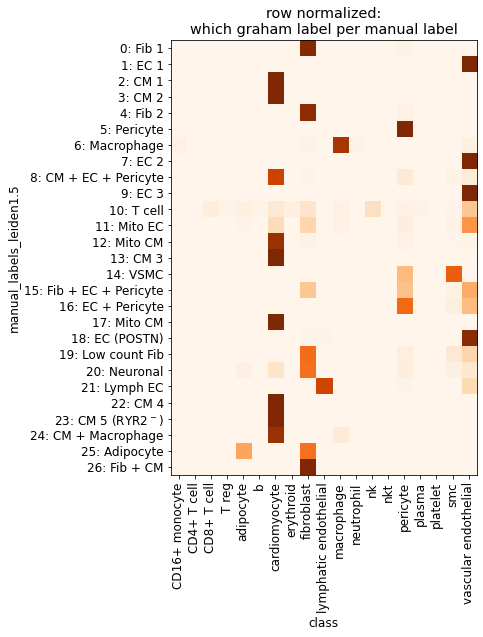

In [40]:
# check overlap of these labels with automatically-generated labels (called "class")

xcol = 'class'
ycol = 'manual_labels_leiden1.5'

df = pd.crosstab(adata.obs[ycol], adata.obs[xcol])
mat = df.to_numpy()

plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(6, 8))
plt.imshow(mat, cmap='Oranges')
plt.yticks(ticks=range(adata.obs[ycol].nunique()), labels=df.index)
plt.ylabel(ycol)
plt.xticks(ticks=range(adata.obs[xcol].nunique()), labels=df.columns, rotation=90)
plt.xlabel(xcol)
plt.title('cells with each label pair: not scaled')
plt.show()

plt.figure(figsize=(6, 8))
plt.imshow(np.log2(mat), cmap='Oranges')
plt.yticks(ticks=range(adata.obs[ycol].nunique()), labels=df.index)
plt.ylabel(ycol)
plt.xticks(ticks=range(adata.obs[xcol].nunique()), labels=df.columns, rotation=90)
plt.xlabel(xcol)
plt.title('log scaled')
plt.show()

plt.figure(figsize=(6, 8))
plt.imshow(mat / mat.sum(axis=0, keepdims=True), cmap='Oranges')
plt.yticks(ticks=range(adata.obs[ycol].nunique()), labels=df.index)
plt.ylabel(ycol)
plt.xticks(ticks=range(adata.obs[xcol].nunique()), labels=df.columns, rotation=90)
plt.xlabel(xcol)
plt.title('column normalized:\nwhich manual label per graham label')
plt.show()

plt.figure(figsize=(6, 8))
plt.imshow(mat / mat.sum(axis=1, keepdims=True), cmap='Oranges')
plt.yticks(ticks=range(adata.obs[ycol].nunique()), labels=df.index)
plt.ylabel(ycol)
plt.xticks(ticks=range(adata.obs[xcol].nunique()), labels=df.columns, rotation=90)
plt.xlabel(xcol)
plt.title('row normalized:\nwhich graham label per manual label')
plt.show()

In [41]:
adata.obs.groupby('manual_labels_leiden1.5').median()

n_genes  n_counts  percent_mito  max_umis  \
manual_labels_leiden1.5                                              
0: Fib 1                   812.0    1150.0      0.000000      47.0   
1: EC 1                    658.0     915.0      0.000000      40.0   
2: CM 1                   1628.0    3603.0      0.000000     285.0   
3: CM 2                    645.0    1076.0      0.000000      93.0   
4: Fib 2                   533.0     704.0      0.000000      29.0   
5: Pericyte                656.0     944.0      0.000000      66.0   
6: Macrophage              603.5     790.0      0.000000      25.0   
7: EC 2                    670.0     917.0      0.000000      29.0   
8: CM + EC + Pericyte     1843.5    3611.5      0.049383     268.0   
9: EC 3                    777.0    1066.0      0.000000      37.0   
10: T cell                 526.5     693.5      0.000000      23.0   
11: Mito EC                524.0     747.0      8.263836      32.0   
12: Mito CM                437.0     701.5      4.856353      44.5   
13: CM 3                  1099.0    2236.0      0.000000     188.0   
14: VSMC                   752.5    1157.5      0.000000     105.5   
15: Fib + EC + Pericyte   1335.0    1963.5      0.000000      92.0   
16: EC + Pericyte         1232.0    1785.0      0.044020      95.5   
17: Mito CM               1216.0    2469.0      3.373016     152.0   
18: EC (POSTN)             630.0     830.0      0.000000      36.0   
19: Low count Fib          436.0     583.0      0.000000      19.0   
20: Neuronal               654.0     928.5      0.115612      30.0   
21: Lymph EC               731.0     993.0      0.000000      31.0   
22: CM 4                  2453.0    7698.0      0.000000     764.0   
23: CM 5 (RYR2$^-$)       2257.5    8793.0      0.000000    1330.0   
24: CM + Macrophage       1580.0    3020.0      0.064537     210.0   
25: Adipocyte             2307.0    5339.0      0.032000     352.0   
26: Fib + CM              4430.5   16799.5      0.020597    1771.0   

                         probability  probability_2  
manual_labels_leiden1.5                              
0: Fib 1                    0.569335       0.100428  
1: EC 1                     0.708700       0.026995  
2: CM 1                     0.905062       0.019812  
3: CM 2                     0.762652       0.030937  
4: Fib 2                    0.415956       0.099493  
5: Pericyte                 0.761063       0.073909  
6: Macrophage               0.593194       0.036962  
7: EC 2                     0.677247       0.021961  
8: CM + EC + Pericyte       0.785937       0.065604  
9: EC 3                     0.709908       0.037216  
10: T cell                  0.204865       0.082132  
11: Mito EC                 0.417988       0.062322  
12: Mito CM                 0.766385       0.028936  
13: CM 3                    0.858844       0.033401  
14: VSMC                    0.585693       0.197050  
15: Fib + EC + Pericyte     0.481316       0.145874  
16: EC + Pericyte           0.609821       0.178647  
17: Mito CM                 0.873562       0.022460  
18: EC (POSTN)              0.462506       0.057403  
19: Low count Fib           0.504202       0.072819  
20: Neuronal                0.155119       0.084531  
21: Lymph EC                0.843942       0.843942  
22: CM 4                    0.900639       0.023292  
23: CM 5 (RYR2$^-$)         0.583426       0.087125  
24: CM + Macrophage         0.846480       0.034433  
25: Adipocyte               0.482991       0.059072  
26: Fib + CM                0.701314       0.073618

In [42]:
adata.write('/home/jupyter-user/analysis/h5ads/broad_heart_review_annotated.h5ad')

In [43]:
adata

AnnData object with n_obs × n_vars = 40880 × 30054
    obs: 'barcodes', 'n_genes', 'n_counts', 'percent_mito', 'method', 'sample', 'doublet', 'max_umis', 'study', 'disease', 'class', 'probability', 'class_2', 'probability_2', 'leiden0.5', 'leiden1.5', 'manual_labels_leiden1.5'
    var: 'featureid-0', 'n_cells-0', 'percent_cells-0', 'robust-0', 'highly_variable_features-0', 'mean-0', 'var-0', 'hvf_loess-0', 'hvf_rank-0', 'bins-0', 'featureid-1', 'n_cells-1', 'percent_cells-1', 'robust-1', 'highly_variable_features-1', 'mean-1', 'var-1', 'hvf_loess-1', 'hvf_rank-1', 'bins-1', 'featureid-10', 'n_cells-10', 'percent_cells-10', 'robust-10', 'highly_variable_features-10', 'mean-10', 'var-10', 'hvf_loess-10', 'hvf_rank-10', 'bins-10', 'featureid-11', 'n_cells-11', 'percent_cells-11', 'robust-11', 'highly_variable_features-11', 'mean-11', 'var-11', 'hvf_loess-11', 'hvf_rank-11', 'bins-11', 'featureid-12', 'n_cells-12', 'percent_cells-12', 'robust-12', 'highly_variable_features-12', 'mean-12', 

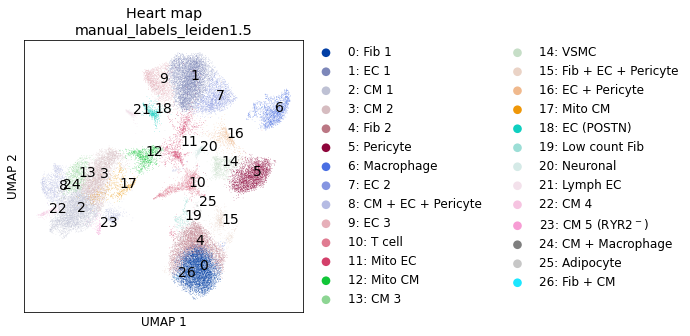

In [44]:
# umap

# show clustering with numbers

key = 'manual_labels_leiden1.5'
# key = 'leiden1.5'
# del adata.uns[key + '_colors']

plt.figure(figsize=(5, 5))
sc.pl.scatter(adata, basis='umap', color=key, 
              ax=plt.gca(), size=1, show=False)

df = pd.DataFrame(adata.obsm['X_umap'])
df['cluster'] = adata.obs[key].values
mean_pos = df.groupby('cluster').median()

for c in mean_pos.index:
    
    plt.gca().text(mean_pos.loc[c][0] + 0.1, 
                   mean_pos.loc[c][1] + 0.01, 
                   c.split(':')[0], 
                   fontsize=14, color='black')

plt.title(f'Heart map\n{key}')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.show()

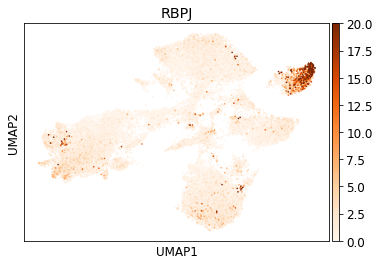

In [45]:
sc.pl.embedding(adata, basis='umap', color=['RBPJ'], 
                color_map='Oranges', vmax=20, size=10)

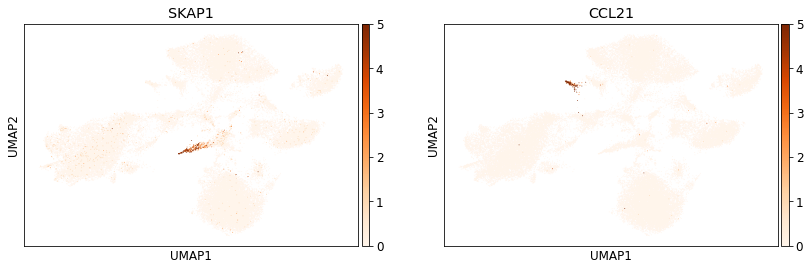

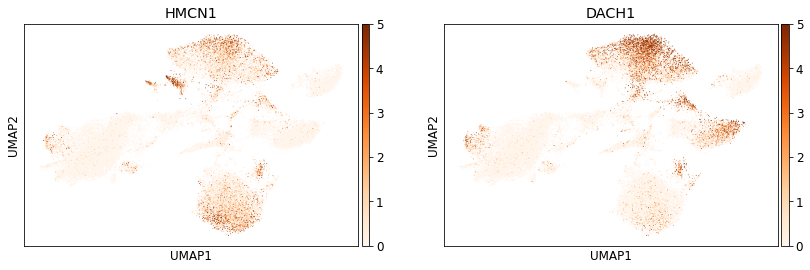

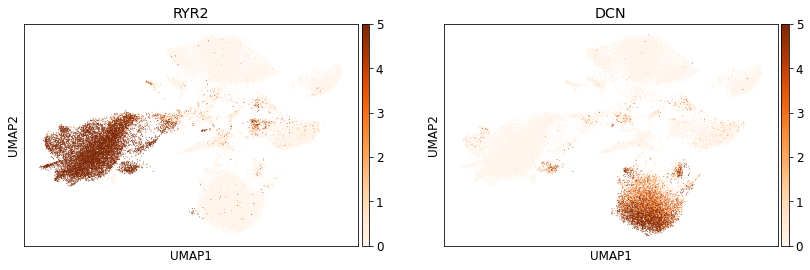

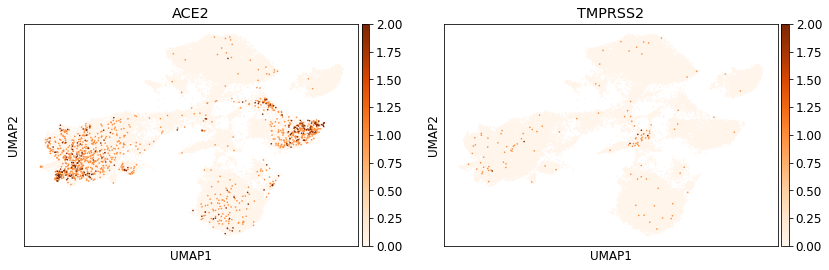

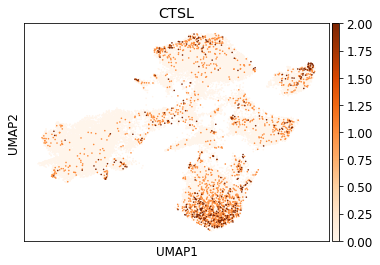

In [46]:
plt.rcParams.update({'font.size': 12})

sc.pl.embedding(adata, basis='umap', color=['SKAP1', 'CCL21'], 
                color_map='Oranges', vmax=5)
sc.pl.embedding(adata, basis='umap', color=['HMCN1', 'DACH1'], 
                color_map='Oranges', vmax=5)
sc.pl.embedding(adata, basis='umap', color=['RYR2', 'DCN'], 
                color_map='Oranges', vmax=5)

sc.pl.embedding(adata, basis='umap', color=['ACE2', 'TMPRSS2'], 
                color_map='Oranges', vmax=2, size=10)
sc.pl.embedding(adata, basis='umap', color=['CTSL'], 
                color_map='Oranges', vmax=2, size=10)

## For figures

In [6]:
adata = sc.read_h5ad('/home/jupyter-user/analysis/h5ads/broad_heart_review_annotated.h5ad')

In [7]:
adata.obs['sample'].value_counts()

02-P005175-S041-R01    10257
02-P118946-S043-R01     5832
02-P348762-S011-R01     3538
02-P240970-S048-R01     3347
12-P617758-S012-R01     2957
04-P079042-S071-R01     2384
13-P999993-S001-R01     2006
04-P006354-S031-R01     1670
12-P852049-S011-R01     1620
04-P054921-S072-R01     1431
12-P890292-S009-R01     1391
02-P248880-S011-R01     1300
13-P999994-S002-R01     1108
13-P999999-S001-R01      818
12-P485759-S012-R01      677
13-P999998-S001-R01      286
02-P166169-S117-R01      186
02-P334354-S012-R01       39
02-P166169-S026-R01       33
Name: sample, dtype: int64

In [8]:
adata.obs.columns

Index(['barcodes', 'n_genes', 'n_counts', 'percent_mito', 'method', 'sample',
       'doublet', 'max_umis', 'study', 'disease', 'class', 'probability',
       'class_2', 'probability_2', 'leiden0.5', 'leiden1.5',
       'manual_labels_leiden1.5'],
      dtype='object')

In [9]:
pd.crosstab(adata.obs['sample'], adata.obs['manual_labels_leiden1.5'])

manual_labels_leiden1.5  0: Fib 1  1: EC 1  2: CM 1  3: CM 2  4: Fib 2  \
sample                                                                   
02-P005175-S041-R01           876      825     1695     1519       663   
02-P118946-S043-R01           566      582      362      544       479   
02-P166169-S026-R01             1        0        0        0         2   
02-P166169-S117-R01            32       16        0        1        28   
02-P240970-S048-R01           332      666      364       91       144   
02-P248880-S011-R01           291      204        1        1       179   
02-P334354-S012-R01             0        6        0        0         2   
02-P348762-S011-R01           648      803      374      315       320   
04-P006354-S031-R01            43      298      199      287        16   
04-P054921-S072-R01            78      351      274      266        48   
04-P079042-S071-R01           550      510       60       69       313   
12-P485759-S012-R01            98       87       88       95        79   
12-P617758-S012-R01           507      561      274      139       272   
12-P852049-S011-R01           222      385      199      124       134   
12-P890292-S009-R01           176       21       83      191        62   
13-P999993-S001-R01           800       63       72       62       396   
13-P999994-S002-R01           525       67        2        7       244   
13-P999998-S001-R01           127       20        0        0        47   
13-P999999-S001-R01           282       41       21       20       167   

manual_labels_leiden1.5  5: Pericyte  6: Macrophage  7: EC 2  \
sample                                                         
02-P005175-S041-R01              758            263      470   
02-P118946-S043-R01              797            173      320   
02-P166169-S026-R01                0              1        0   
02-P166169-S117-R01               24              2        9   
02-P240970-S048-R01              281            148      193   
02-P248880-S011-R01              130             45       38   
02-P334354-S012-R01                3              0        0   
02-P348762-S011-R01              210             95      140   
04-P006354-S031-R01               19             69       52   
04-P054921-S072-R01               51             28       59   
04-P079042-S071-R01               87             22      213   
12-P485759-S012-R01               32             36       17   
12-P617758-S012-R01              180            317       82   
12-P852049-S011-R01               97             95       57   
12-P890292-S009-R01               20             76       16   
13-P999993-S001-R01               82            196        9   
13-P999994-S002-R01               46             80       11   
13-P999998-S001-R01               16              7        5   
13-P999999-S001-R01               58             63        5   

manual_labels_leiden1.5  8: CM + EC + Pericyte  9: EC 3  ...  17: Mito CM  \
sample                                                   ...                
02-P005175-S041-R01                        938      318  ...           58   
02-P118946-S043-R01                        343      185  ...           47   
02-P166169-S026-R01                          0        7  ...            0   
02-P166169-S117-R01                          0       22  ...            0   
02-P240970-S048-R01                         63      155  ...          112   
02-P248880-S011-R01                          0       77  ...            0   
02-P334354-S012-R01                          0        2  ...            0   
02-P348762-S011-R01                         52      202  ...           28   
04-P006354-S031-R01                          7       79  ...           81   
04-P054921-S072-R01                         22      103  ...            4   
04-P079042-S071-R01                         12       91  ...           11   
12-P485759-S012-R01                          4       14  ...           22   
12-P617758-S012-R01   

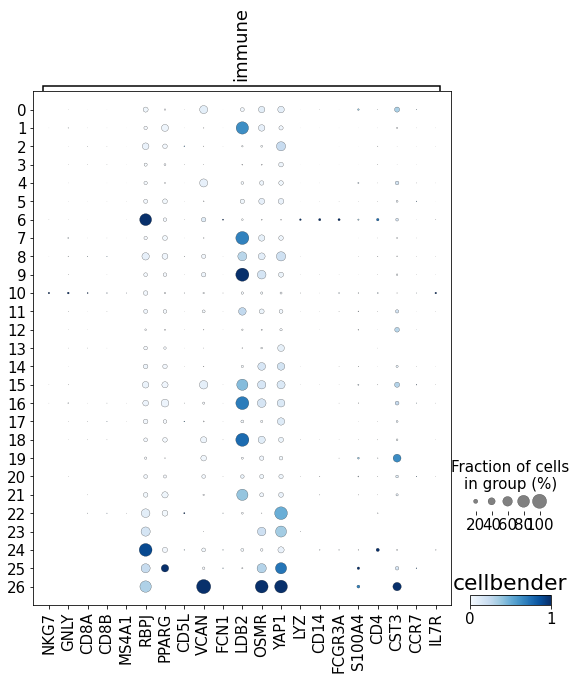

In [8]:
# plot marker genes for the outlier "clusters"
n = 15

cluster_key = 'leiden1.5'

marker_key = 'rank_genes_groups_' + cluster_key

marker_genes = np.array(adata.uns[marker_key]['names'][:(n + 10)].tolist(), 
                        dtype=str).transpose()
unique_markers = {}
for k in range(marker_genes.shape[0]):
    i = 0
    genes = []
    for g in marker_genes[k, :]:
        if ((i < n) 
            and (g not in genes) 
            and (g not in [a for it in list(unique_markers.values()) for a in it]) 
            and (g != 'nan')):
            genes.append(g)
            i += 1
    unique_markers.update({adata.obs[cluster_key].value_counts().index[k]: genes})

# unique_markers = {'20': unique_markers['20']}
unique_markers = {'immune': ['NKG7', 'GNLY', 'CD8A', 'CD8B', 
                         'MS4A1', 
                         'RBPJ', 'PPARG', 'CD5L', 'VCAN', 'FCN1', 'LDB2', 'OSMR', 'YAP1',
                         'LYZ', 'CD14', 'FCGR3A', 'S100A4', 'CD4', 'CST3', 'CCR7', 'IL7R']}
plt.rcParams.update({'font.size': 18})

sc.pl.dotplot(adata, 
              var_names=unique_markers, 
              layer='counts',
              groupby=cluster_key,
#               log=True,
              standard_scale='var',
              color_map='Blues',
              smallest_dot=2,
              show=False)
plt.title('cellbender')
plt.show()

## Extended Data Figure 11c

In [ ]:
adata.X = adata.layers['counts'].copy()
sc.pp.normalize_total(adata)

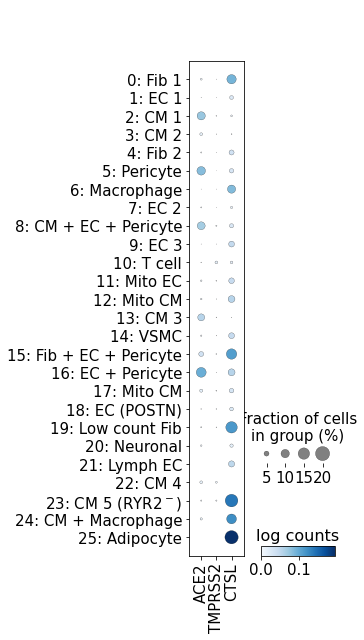

In [11]:
# plot marker genes for the outlier "clusters"

cluster_key = 'manual_labels_leiden1.5'

plt.rcParams.update({'font.size': 18})

sc.pl.dotplot(adata[adata.obs['leiden1.5'] != '26'], 
              var_names=['ACE2', 'TMPRSS2', 'CTSL'], 
              layer='counts',
              groupby=cluster_key,
              log=True,
#               standard_scale='var',
              color_map='Blues',
              smallest_dot=15,
              show=False)
plt.title('log counts', fontsize=16)
plt.gcf().savefig('heart_covid_receptors_dotplot.pdf', bbox_inches='tight')
plt.show()

In [73]:
adata.obs.keys()

Index(['barcodes', 'n_genes', 'n_counts', 'percent_mito', 'method', 'sample',
       'doublet', 'max_umis', 'study', 'disease', 'class', 'probability',
       'class_2', 'probability_2', 'leiden0.5', 'leiden1.5',
       'manual_labels_leiden1.5', 'display_sample'],
      dtype='object')

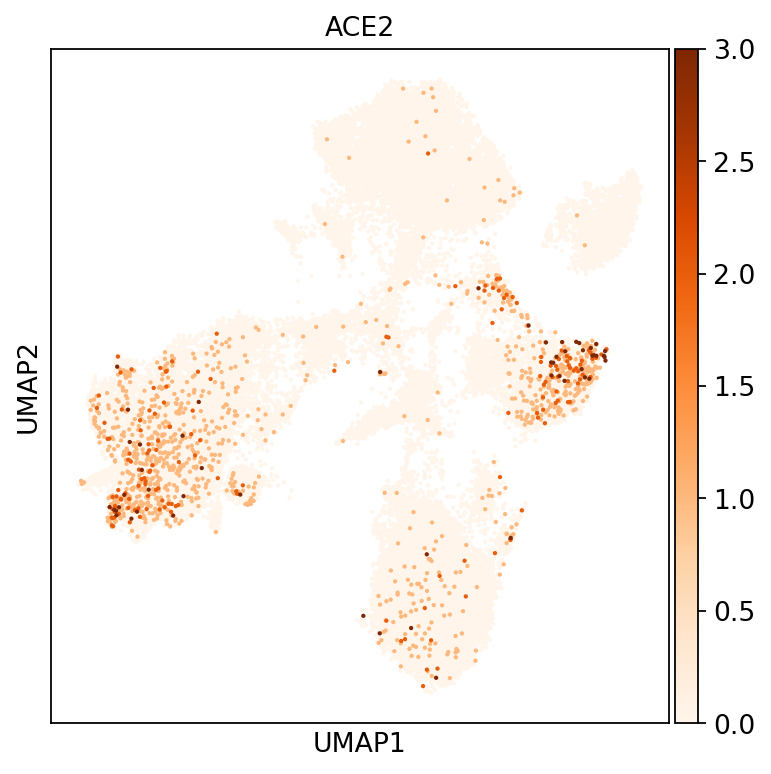

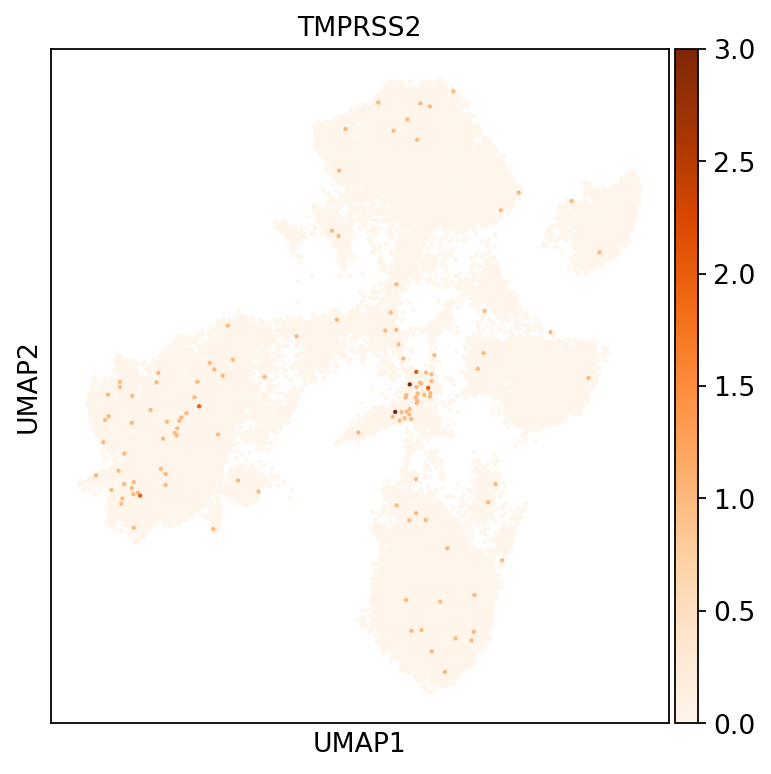

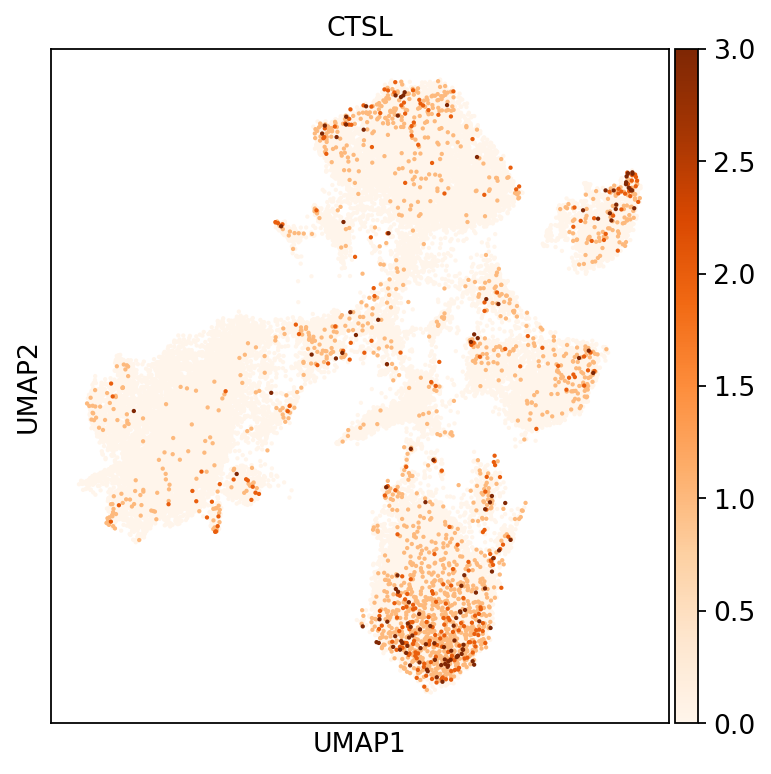

In [54]:
plt.rcParams.update({'font.size': 10})
sc.set_figure_params(vector_friendly=True, fontsize=12)

for gene in ['ACE2', 'TMPRSS2', 'CTSL']:

    plt.figure(figsize=(5, 5))
    sc.pl.embedding(adata, basis='umap', color=gene, color_map='Oranges', 
                    ax=plt.gca(), size=15, vmax=3, show=False)
    plt.tight_layout()
    plt.gcf().savefig(f'heart_umap_{gene}.pdf', bbox_inches='tight')
    plt.show()

In [12]:
# colors

vent_cm_color = '#111111'
low_vent_cm_color = '#555555'
sample_specific = '#635547'
mito_color = low_vent_cm_color

colormapping = {'EC': '#f9be61',
                'Fib': '#b3e08b',
                'CM': vent_cm_color,
                'Pericyte': '#e7ab01',
                'Macrophage': '#1864b1',
                'VSMC': '#8b3174',
                'Lymph': '#a7751b',
                'T cell': '#8dd3c7',
                'Neuro': '#dc060d',
                'Low': low_vent_cm_color,
                'Adipocyte': '#881111',
                'Mito': mito_color,
                '+': '#999999',
                }

color_palette = {}

for k in adata.obs['manual_labels_leiden1.5'].value_counts().index:
    
    for key, value in colormapping.items():
        # go through in order of increasing priority and match
        if key in k:
            c = value
            
    color_palette.update({k: c})
    
    print(k.ljust(25), '\t-->\t', c)

adata.uns['manual_labels_leiden1.5_colors'] = list(color_palette.values())

0: Fib 1                  	-->	 #b3e08b
1: EC 1                   	-->	 #f9be61
2: CM 1                   	-->	 #111111
3: CM 2                   	-->	 #111111
4: Fib 2                  	-->	 #b3e08b
5: Pericyte               	-->	 #e7ab01
6: Macrophage             	-->	 #1864b1
7: EC 2                   	-->	 #f9be61
8: CM + EC + Pericyte     	-->	 #999999
9: EC 3                   	-->	 #f9be61
10: T cell                	-->	 #8dd3c7
11: Mito EC               	-->	 #555555
12: Mito CM               	-->	 #555555
13: CM 3                  	-->	 #111111
14: VSMC                  	-->	 #8b3174
15: Fib + EC + Pericyte   	-->	 #999999
16: EC + Pericyte         	-->	 #999999
17: Mito CM               	-->	 #555555
18: EC (POSTN)            	-->	 #f9be61
19: Low count Fib         	-->	 #555555
20: Neuronal              	-->	 #dc060d
21: Lymph EC              	-->	 #a7751b
22: CM 4                  	-->	 #111111
23: CM 5 (RYR2$^-$)       	-->	 #111111
24: CM + Macrophage       	-->	 #999999


In [13]:
patient_lookup = dict(zip([
'02-P005175',
'02-P118946',
'02-P166169',
'02-P240970',
'02-P248880',
'02-P334354',
'02-P348762',
'04-P006354',
'04-P024506',
'04-P054921',
'04-P079042',
'04-P103142',
'12-P230638',
'12-P485759',
'12-P617758',
'12-P852049',
'12-P890292',
'13-P999993',
'13-P999994',
'13-P999998',
'13-P999999'], [
'D1',
'D2',
'D3',
'D4',
'D5',
'D6',
'D7',
'D8',
'D9',
'D10',
'D11',
'D12',
'D13',
'D14',
'D15',
'D16',
'D17',
'D27',
'D28',
'D31',
'D32']))

def name_sample(s):
    return (patient_lookup[s[:10]] + '_heart' 
            + ('1' if (s == '02-P166169-S026-R01') else '') 
            + ('2' if (s == '02-P166169-S117-R01') else ''))

sample_lookup = dict(zip(adata.obs['sample'].unique(), 
                         [name_sample(s) for s in adata.obs['sample'].unique()]))
print(sample_lookup)

adata.obs['display_sample'] = \
    adata.obs['sample'].apply(lambda s: sample_lookup[s]).astype('category')
adata.obs['display_sample'].cat.reorder_categories(
    ['D1_heart', 'D2_heart', 'D3_heart1', 'D3_heart2', 
     'D4_heart', 'D5_heart', 'D6_heart', 'D7_heart', 
     'D8_heart', 'D10_heart', 'D11_heart', 'D14_heart', 
     'D15_heart', 'D16_heart', 'D17_heart', 
     'D27_heart', 'D28_heart', 'D31_heart', 'D32_heart'][::-1], inplace=True)

{'02-P166169-S117-R01': 'D3_heart2', '02-P248880-S011-R01': 'D5_heart', '02-P005175-S041-R01': 'D1_heart', '02-P118946-S043-R01': 'D2_heart', '02-P166169-S026-R01': 'D3_heart1', '02-P240970-S048-R01': 'D4_heart', '02-P334354-S012-R01': 'D6_heart', '02-P348762-S011-R01': 'D7_heart', '04-P054921-S072-R01': 'D10_heart', '04-P079042-S071-R01': 'D11_heart', '04-P006354-S031-R01': 'D8_heart', '12-P485759-S012-R01': 'D14_heart', '12-P617758-S012-R01': 'D15_heart', '12-P852049-S011-R01': 'D16_heart', '12-P890292-S009-R01': 'D17_heart', '13-P999999-S001-R01': 'D32_heart', '13-P999998-S001-R01': 'D31_heart', '13-P999994-S002-R01': 'D28_heart', '13-P999993-S001-R01': 'D27_heart'}


In [14]:
adata.obs['display_sample'].astype(str).unique().tolist()

['D3_heart2',
 'D5_heart',
 'D1_heart',
 'D2_heart',
 'D3_heart1',
 'D4_heart',
 'D6_heart',
 'D7_heart',
 'D10_heart',
 'D11_heart',
 'D8_heart',
 'D14_heart',
 'D15_heart',
 'D16_heart',
 'D17_heart',
 'D32_heart',
 'D31_heart',
 'D28_heart',
 'D27_heart']

In [15]:
adata.obs['sample'].unique().tolist()

['02-P166169-S117-R01',
 '02-P248880-S011-R01',
 '02-P005175-S041-R01',
 '02-P118946-S043-R01',
 '02-P166169-S026-R01',
 '02-P240970-S048-R01',
 '02-P334354-S012-R01',
 '02-P348762-S011-R01',
 '04-P054921-S072-R01',
 '04-P079042-S071-R01',
 '04-P006354-S031-R01',
 '12-P485759-S012-R01',
 '12-P617758-S012-R01',
 '12-P852049-S011-R01',
 '12-P890292-S009-R01',
 '13-P999999-S001-R01',
 '13-P999998-S001-R01',
 '13-P999994-S002-R01',
 '13-P999993-S001-R01']

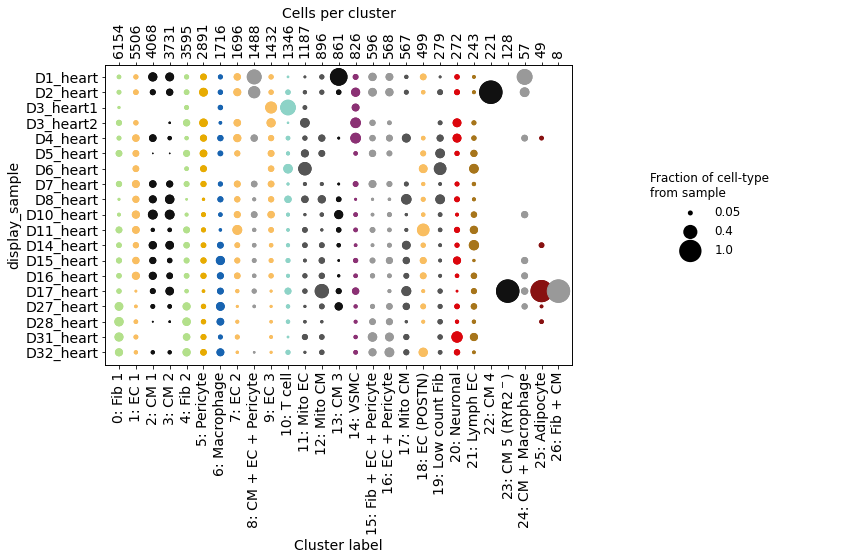

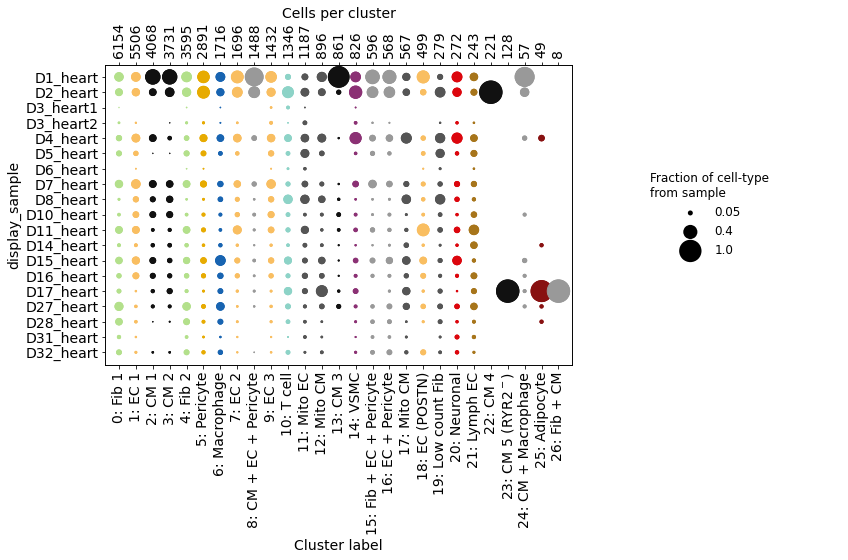

In [16]:
from sc_utils import cell_count_dotplot, _dot_size_legend

size_factor = 1.

plt.rcParams.update({'font.size': 14})
cell_count_dotplot(adata, 
                   figsize=(12, 8),
                   key='display_sample', cluster_key='manual_labels_leiden1.5', 
                   normalize='row_then_column', 
                   xrotation=90, size_factor=size_factor, show=False)
# plt.tight_layout()
_dot_size_legend(sizes=np.array([0.05, 0.4, 1]),
                 display_scale_fcn=lambda x: x * 500 * size_factor, 
                 marker='o', 
                 title='Fraction of cell-type\nfrom sample')
plt.tight_layout()
plt.gcf().savefig('heart_cell_dotplot.pdf', bbox_to_inches='tight')
plt.show()

cell_count_dotplot(adata, 
                   figsize=(12, 8),
                   key='display_sample', cluster_key='manual_labels_leiden1.5', 
                   normalize='column', 
                   xrotation=90, size_factor=size_factor, show=False)
# plt.tight_layout()
_dot_size_legend(sizes=np.array([0.05, 0.4, 1]),
                 display_scale_fcn=lambda x: x * 500 * size_factor, 
                 marker='o', 
                 title='Fraction of cell-type\nfrom sample')
plt.tight_layout()
plt.gcf().savefig('heart_cell_dotplot_just_column_normalized.pdf', bbox_to_inches='tight')
plt.show()

In [18]:
adata.obs['display_sample'].cat.reorder_categories(
    adata.obs['display_sample'].cat.categories[::-1], inplace=True,
)

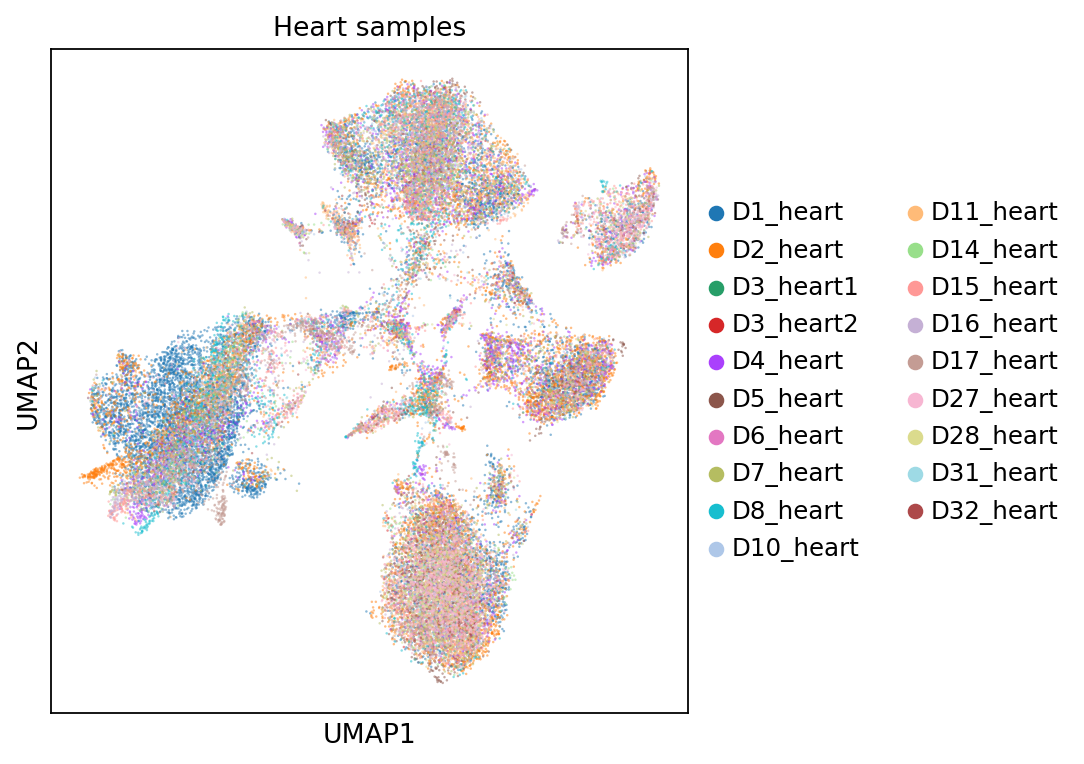

In [87]:
plt.figure(figsize=(7, 5))
sc.pl.embedding(adata, basis='umap', color='display_sample', color_map='Oranges', 
                ax=plt.gca(), size=5, alpha=0.5, show=False)
plt.title('Heart samples')
plt.tight_layout()
plt.gcf().savefig(f'heart_umap_sample_labels.pdf', bbox_inches='tight')
plt.show()

## Extended Data Figure 10c

... storing 'individual' as categorical


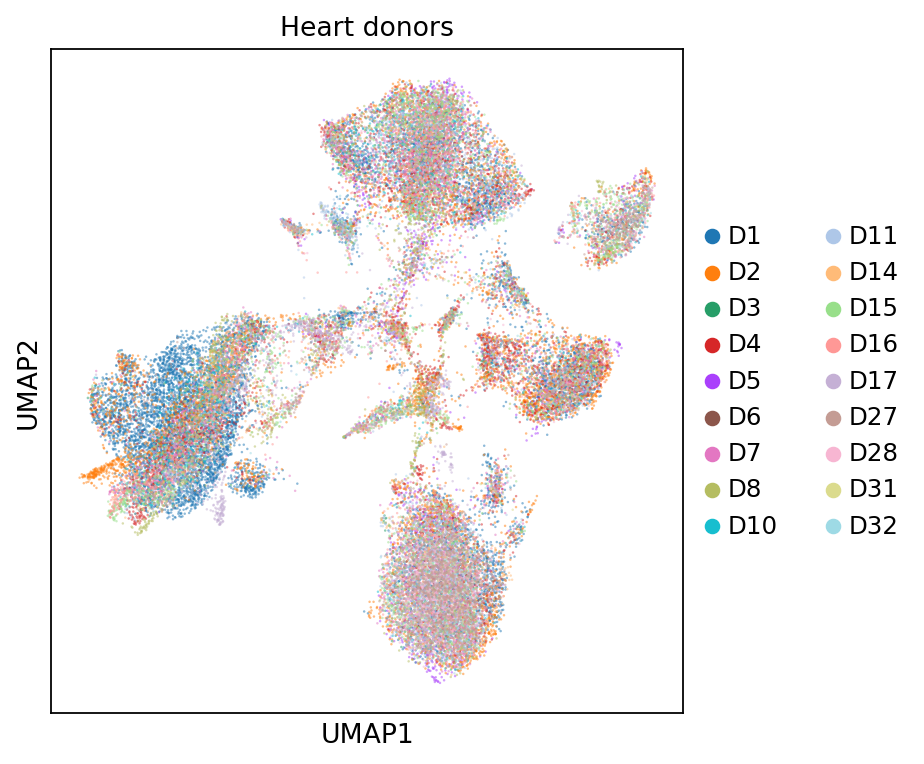

In [89]:
adata.obs['individual'] = adata.obs['display_sample'].apply(lambda s: s.split('_')[0])

plt.figure(figsize=(6, 5))
sc.pl.embedding(adata, basis='umap', color='individual', color_map='Oranges', 
                ax=plt.gca(), size=5, alpha=0.5, show=False)
plt.title('Heart donors')
plt.tight_layout()
plt.gcf().savefig(f'heart_umap_individual.pdf', bbox_inches='tight')
plt.show()

## Extended Data Figure 10a

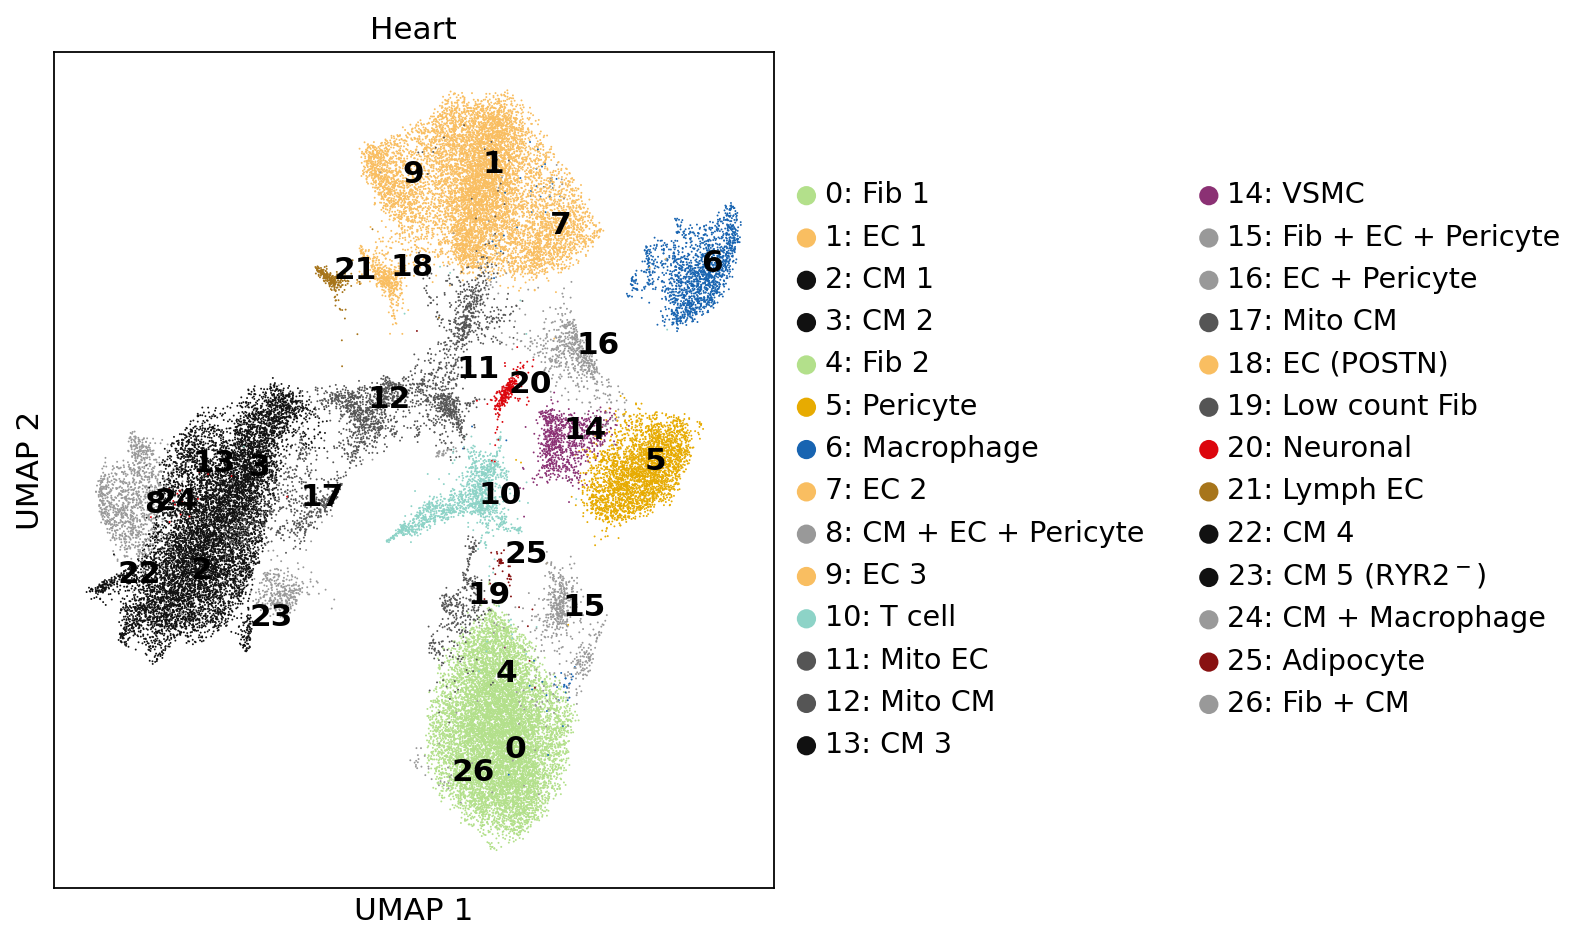

In [19]:
# umap

sc.set_figure_params(vector_friendly=True)

plt.rcParams.update({'font.size': 10})

# show clustering with numbers

key = 'manual_labels_leiden1.5'
colors = list(color_palette.values())
# colors = [tuple(int(c.lstrip('#')[i:i+2], 16) 
#           for i in (0, 2, 4)) for c in colors]
adata.uns[key + '_colors'] = colors

plt.figure(figsize=(10, 6))
sc.pl.scatter(adata, basis='umap', color=key, 
              ax=plt.gca(), size=3, show=False, palette=colors)

df = pd.DataFrame(adata.obsm['X_umap'])
df['cluster'] = adata.obs[key].values
mean_pos = df.groupby('cluster').median()

for c in mean_pos.index:
    
    plt.gca().text(mean_pos.loc[c][0] + 0.1, 
                   mean_pos.loc[c][1] + 0.01, 
                   c.split(':')[0], 
                   fontsize=14, color='black', fontweight='bold')

plt.title(f'Heart', fontsize=14)
plt.xlabel('UMAP 1', fontsize=14)
plt.ylabel('UMAP 2', fontsize=14)

plt.tight_layout()

plt.gcf().savefig('heart_umap_manual_labels.pdf', bbox_to_inches='tight')

plt.show()

In [15]:
adata.obs['class'].value_counts()

cardiomyocyte            12007
vascular endothelial     10812
fibroblast               10529
pericyte                  4273
macrophage                1575
smc                        751
nk                         222
lymphatic endothelial      208
adipocyte                  122
CD8+ T cell                 94
erythroid                   72
CD16+ monocyte              63
neutrophil                  45
plasma                      36
b                           26
T reg                       26
nkt                         11
platelet                     7
CD4+ T cell                  1
Name: class, dtype: int64

In [47]:
# colors

vent_cm_color = '#111111'
low_vent_cm_color = '#555555'
sample_specific = '#635547'
mito_color = low_vent_cm_color

colormapping = {'b': '#7571b4',
                'vascular endothelial': '#f9be61',
                'fibroblast': '#b3e08b',
                'cardiomyocyte': vent_cm_color,
                'pericyte': '#e7ab01',
                'macrophage': '#1864b1',
                'smc': '#8b3174',
                'lymphatic endothelial': '#a7751b',
                'T cell': '#8dd3c7',
                'adipocyte': '#881111',
                'CD8+ T cell': '#adadad',
                'T reg': '#000000',
                'nk': '#8dd3c7',
                'nkt': '#C9EBFB',
                'plasma': '#ff7d04',
                'CD4+ T cell': '#666666',
                'CD16+ monocyte': '#F8E4BC',
                'erythroid': '#dadada',
                'neutrophil': '#b17ba8',
                'platelet': '#dc1111',
                }

In [48]:
adata.obs['class'].cat.categories

Index(['CD16+ monocyte', 'CD4+ T cell', 'CD8+ T cell', 'T reg', 'adipocyte',
       'b', 'cardiomyocyte', 'erythroid', 'fibroblast',
       'lymphatic endothelial', 'macrophage', 'neutrophil', 'nk', 'nkt',
       'pericyte', 'plasma', 'platelet', 'smc', 'vascular endothelial'],
      dtype='object')

In [55]:
adata_subset = adata[adata.obs['class'].isin(adata.obs['class'].value_counts().index
                                            [adata.obs['class'].value_counts().values > 10])]

In [56]:
color_palette = {}

for k in adata_subset.obs['class'].cat.categories:
#     print(k)
    
    c = None
    for key, value in colormapping.items():
        # go through in order of increasing priority and match
        if key == k:
            c = value
    if c is None:
        raise ValueError(k)
#             print('match with', key)
            
    color_palette.update({k: c})
    
    print(k.ljust(25), '\t-->\t', c)

adata_subset.uns['class_colors'] = list(color_palette.values())

Trying to set attribute `.uns` of view, copying.


CD16+ monocyte            	-->	 #F8E4BC
CD8+ T cell               	-->	 #adadad
T reg                     	-->	 #000000
adipocyte                 	-->	 #881111
b                         	-->	 #7571b4
cardiomyocyte             	-->	 #111111
erythroid                 	-->	 #dadada
fibroblast                	-->	 #b3e08b
lymphatic endothelial     	-->	 #a7751b
macrophage                	-->	 #1864b1
neutrophil                	-->	 #b17ba8
nk                        	-->	 #8dd3c7
nkt                       	-->	 #C9EBFB
pericyte                  	-->	 #e7ab01
plasma                    	-->	 #ff7d04
smc                       	-->	 #8b3174
vascular endothelial      	-->	 #f9be61


## Extended Data Figure 10j

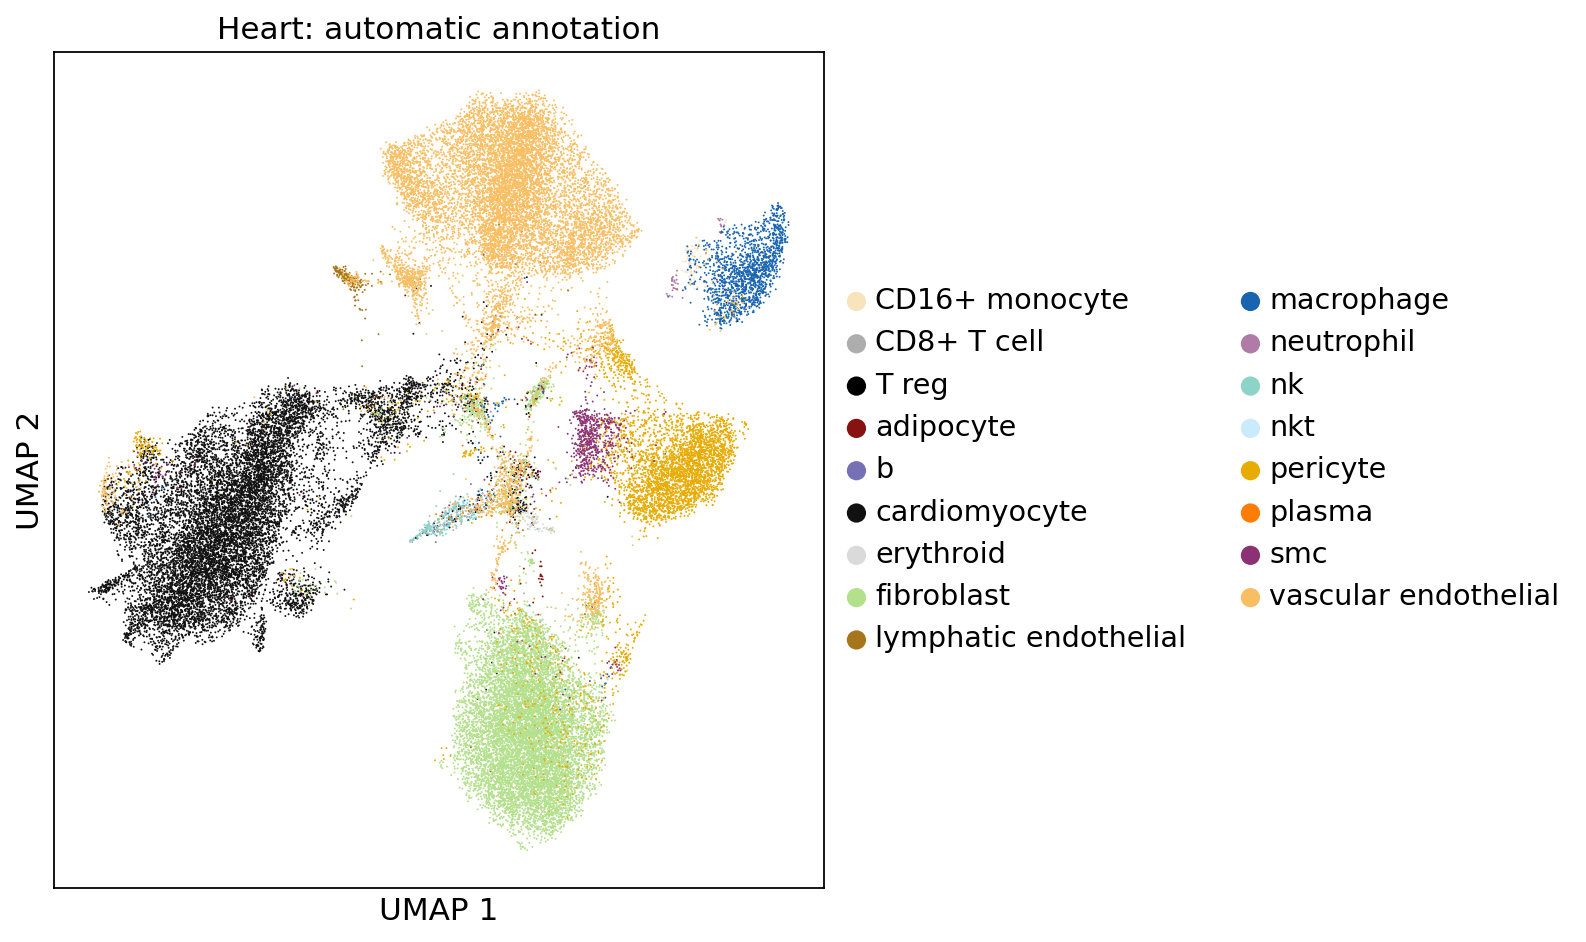

In [61]:
# umap

sc.set_figure_params(vector_friendly=True)

plt.rcParams.update({'font.size': 10})

# show clustering with numbers

key = 'class'
colors = list(color_palette.values())
# colors = [tuple(int(c.lstrip('#')[i:i+2], 16) 
#           for i in (0, 2, 4)) for c in colors]
adata.uns[key + '_colors'] = colors

plt.figure(figsize=(10, 6))
sc.pl.scatter(adata_subset, 
              basis='umap', color=key, 
              ax=plt.gca(), size=3, show=False, palette=colors)

# df = pd.DataFrame(adata.obsm['X_umap'])
# df['cluster'] = adata.obs[key].values
# mean_pos = df.groupby('cluster').median()

# for c in mean_pos.index:
    
#     plt.gca().text(mean_pos.loc[c][0] + 0.1, 
#                    mean_pos.loc[c][1] + 0.01, 
#                    c.split(':')[0], 
#                    fontsize=14, color='black', fontweight='bold')

plt.title(f'Heart: automatic annotation', fontsize=14)
plt.xlabel('UMAP 1', fontsize=14)
plt.ylabel('UMAP 2', fontsize=14)

plt.tight_layout()

plt.gcf().savefig('heart_umap_automatic_labels.pdf', bbox_to_inches='tight')

plt.show()

### Cell type composition barplot

In [51]:
adata.obs['display_sample'].cat.reorder_categories(
    adata.obs['display_sample'].cat.categories[::-1], inplace=True,
)

In [62]:
adata.obs['donor'] = adata.obs['display_sample'].apply(lambda s: s.split('_')[0]).astype('category')

In [63]:
adata.obs['donor'].value_counts().index.tolist()

['D1',
 'D2',
 'D7',
 'D4',
 'D15',
 'D11',
 'D27',
 'D8',
 'D16',
 'D10',
 'D17',
 'D5',
 'D28',
 'D32',
 'D14',
 'D31',
 'D3',
 'D6']

In [66]:
adata.obs['donor'].cat.reorder_categories(
np.array(['D1',
'D2',
'D3',
'D4',
'D5',
'D6',
'D7',
'D8',
'D10',
'D11',
'D14',
'D15',
'D16',
'D17',
'D27',
'D28',
'D31',
'D32',
])[::-1], inplace=True,
)

In [45]:
adata.obs['manual_labels_leiden1.5'].cat.reorder_categories(
    ['0: Fib 1',
     '4: Fib 2',
     '1: EC 1',
     '7: EC 2',
     '9: EC 3',
     '18: EC (POSTN)',
     '2: CM 1',
     '3: CM 2',
     '13: CM 3',
     '22: CM 4',
     '23: CM 5 (RYR2$^-$)',
     '5: Pericyte',
     '6: Macrophage',
     '10: T cell',
     '14: VSMC',
     '20: Neuronal',
     '21: Lymph EC',
     '25: Adipocyte',
     '11: Mito EC',
     '12: Mito CM',
     '17: Mito CM',
     '19: Low count Fib',
     '8: CM + EC + Pericyte',
     '15: Fib + EC + Pericyte',
     '16: EC + Pericyte',
     '24: CM + Macrophage',
     '26: Fib + CM'],
    inplace=True,
)

In [47]:
# colors

vent_cm_color = '#111111'
low_vent_cm_color = '#555555'
sample_specific = '#635547'
mito_color = low_vent_cm_color

colormapping = {'EC': '#f9be61',
                'Fib': '#b3e08b',
                'CM': vent_cm_color,
                'Pericyte': '#e7ab01',
                'Macrophage': '#1864b1',
                'VSMC': '#8b3174',
                'Lymph': '#a7751b',
                'T cell': '#8dd3c7',
                'Neuro': '#dc060d',
                'Adipocyte': '#881111',
                'Low': low_vent_cm_color,
                'Mito': mito_color,
                '+': '#999999',
                }

color_palette = {}

for k in adata.obs['manual_labels_leiden1.5'].cat.categories:
    
    for key, value in colormapping.items():
        # go through in order of increasing priority and match
        if key in k:
            c = value
            
    color_palette.update({k: c})
    
    print(k.ljust(25), '\t-->\t', c)

adata.uns['manual_labels_leiden1.5_colors'] = list(color_palette.values())

0: Fib 1                  	-->	 #b3e08b
4: Fib 2                  	-->	 #b3e08b
1: EC 1                   	-->	 #f9be61
7: EC 2                   	-->	 #f9be61
9: EC 3                   	-->	 #f9be61
18: EC (POSTN)            	-->	 #f9be61
2: CM 1                   	-->	 #111111
3: CM 2                   	-->	 #111111
13: CM 3                  	-->	 #111111
22: CM 4                  	-->	 #111111
23: CM 5 (RYR2$^-$)       	-->	 #111111
5: Pericyte               	-->	 #e7ab01
6: Macrophage             	-->	 #1864b1
10: T cell                	-->	 #8dd3c7
14: VSMC                  	-->	 #8b3174
20: Neuronal              	-->	 #dc060d
21: Lymph EC              	-->	 #a7751b
25: Adipocyte             	-->	 #881111
11: Mito EC               	-->	 #555555
12: Mito CM               	-->	 #555555
17: Mito CM               	-->	 #555555
19: Low count Fib         	-->	 #555555
8: CM + EC + Pericyte     	-->	 #999999
15: Fib + EC + Pericyte   	-->	 #999999
16: EC + Pericyte         	-->	 #999999


## Extended Data Figure 10b

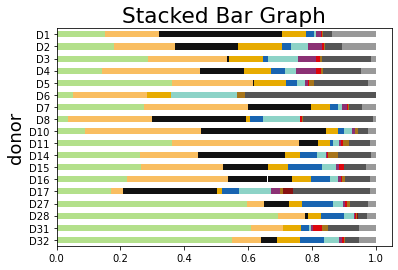

In [71]:
df = pd.crosstab(adata.obs['donor'], adata.obs['manual_labels_leiden1.5'])

# normalize so rows sum to one

df = pd.DataFrame(data=df.values / np.sum(df.values, axis=1, keepdims=True), 
                  index=df.index, 
                  columns=df.columns)

# attempt at one of the bar plots

from matplotlib.colors import ListedColormap

newcmp = ListedColormap(adata.uns['manual_labels_leiden1.5_colors'])

df.plot(
#     x = 'display_sample', 
    kind = 'barh', 
    stacked = True, 
    title = 'Stacked Bar Graph', 
    colormap=newcmp,
#     mark_right = True,
    fontsize=10,
    legend=False,
) 

plt.savefig('heart_cell_proportion_barplot.pdf', bbox_inches='tight')
plt.show()

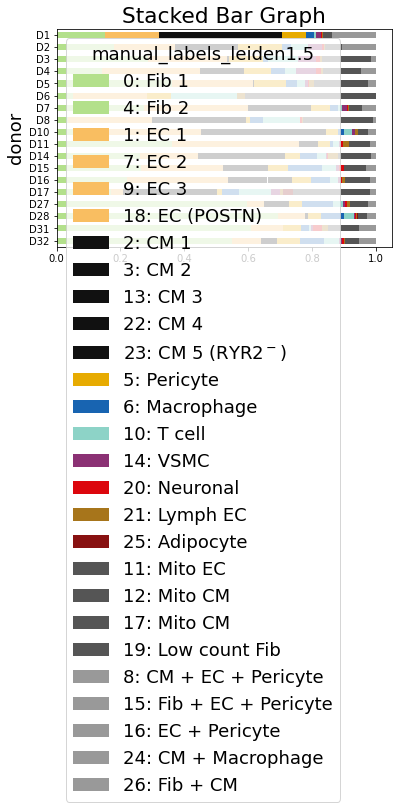

In [70]:
df = pd.crosstab(adata.obs['donor'], adata.obs['manual_labels_leiden1.5'])

# normalize so rows sum to one

df = pd.DataFrame(data=df.values / np.sum(df.values, axis=1, keepdims=True), 
                  index=df.index, 
                  columns=df.columns)

# attempt at one of the bar plots

from matplotlib.colors import ListedColormap

newcmp = ListedColormap(adata.uns['manual_labels_leiden1.5_colors'])

df.plot(
#     x = 'display_sample', 
    kind = 'barh', 
    stacked = True, 
    title = 'Stacked Bar Graph', 
    colormap=newcmp,
#     mark_right = True,
    fontsize=10,
    legend='right',
) 

plt.savefig('heart_cell_proportion_barplot_legend.pdf', bbox_inches='tight')
plt.show()

In [72]:
!gsutil cp heart_cell_proportion_barplot*.pdf gs://fc-7e30ec48-0a0c-484f-a784-b6c7f44dd2c7/notebooks

Copying file://heart_cell_proportion_barplot.pdf [Content-Type=application/pdf]...
Copying file://heart_cell_proportion_barplot_legend.pdf [Content-Type=application/pdf]...
/ [2 files][ 48.2 KiB/ 48.2 KiB]                                                
Operation completed over 2 objects/48.2 KiB.                                     


#### Annotations for handoff to Graham

In [66]:
# adata.write('/home/jupyter-user/analysis/h5ads/broad_heart_review_annotated_20210121.h5ad')

In [67]:
# adata

In [68]:
# !gsutil cp /home/jupyter-user/analysis/h5ads/broad_heart_review_annotated_20210121.h5ad gs://fc-7e30ec48-0a0c-484f-a784-b6c7f44dd2c7/notebooks

## Cleanup: ... if we can go that route?

In [55]:
adata = sc.read_h5ad('/home/jupyter-user/analysis/h5ads/broad_heart_review_annotated_20210121.h5ad')

In [56]:
adata.obs['manual_labels_leiden1.5'].value_counts()

0: Fib 1                   6154
1: EC 1                    5506
2: CM 1                    4068
3: CM 2                    3731
4: Fib 2                   3595
5: Pericyte                2891
6: Macrophage              1716
7: EC 2                    1696
8: CM + EC + Pericyte      1488
9: EC 3                    1432
10: T cell                 1346
11: Mito EC                1187
12: Mito CM                 896
13: CM 3                    861
14: VSMC                    826
15: Fib + EC + Pericyte     596
16: EC + Pericyte           568
17: Mito CM                 567
18: EC (POSTN)              499
19: Low count Fib           279
20: Neuronal                272
21: Lymph EC                243
22: CM 4                    221
23: CM 5 (RYR2$^-$)         128
24: CM + Macrophage          57
25: Adipocyte                49
26: Fib + CM                  8
Name: manual_labels_leiden1.5, dtype: int64

Get rid of junk clusters

In [57]:
mt_junk_clusters = ['11', '12', '17', '19']
doublets = ['8', '15', '16', '26']

In [58]:
adata_clean = adata[~adata.obs['leiden1.5'].isin(mt_junk_clusters + doublets)].copy()

In [59]:
adata_clean

AnnData object with n_obs × n_vars = 35291 × 30054
    obs: 'barcodes', 'n_genes', 'n_counts', 'percent_mito', 'method', 'sample', 'doublet', 'max_umis', 'study', 'disease', 'class', 'probability', 'class_2', 'probability_2', 'leiden0.5', 'leiden1.5', 'leiden1.0', 'manual_labels_leiden1.0', 'manual_labels_leiden1.5', 'display_sample'
    var: 'featureid-0', 'n_cells-0', 'percent_cells-0', 'robust-0', 'highly_variable_features-0', 'mean-0', 'var-0', 'hvf_loess-0', 'hvf_rank-0', 'bins-0', 'featureid-1', 'n_cells-1', 'percent_cells-1', 'robust-1', 'highly_variable_features-1', 'mean-1', 'var-1', 'hvf_loess-1', 'hvf_rank-1', 'bins-1', 'featureid-10', 'n_cells-10', 'percent_cells-10', 'robust-10', 'highly_variable_features-10', 'mean-10', 'var-10', 'hvf_loess-10', 'hvf_rank-10', 'bins-10', 'featureid-11', 'n_cells-11', 'percent_cells-11', 'robust-11', 'highly_variable_features-11', 'mean-11', 'var-11', 'hvf_loess-11', 'hvf_rank-11', 'bins-11', 'featureid-12', 'n_cells-12', 'percent_cells-12

## Re-do analysis from PCA on

In [60]:
# # run PCA using these highly variable genes

# # adata_clean.var['highly_variable'] = hvg

# # normalize and log scale
# adata_clean.X = adata_clean.layers['counts'].copy()
# sc.pp.normalize_total(adata_clean)
# sc.pp.log1p(adata_clean)

# # do PCA
# sc.tl.pca(adata_clean, n_comps=50, use_highly_variable=True)

# # batch-correct with Harmony

# adata_clean.obsm['X_harmony'] = harmonize(adata_clean.obsm['X_pca'], adata_clean.obs, batch_key='sample')

# sc.pp.neighbors(adata_clean, use_rep='X_harmony')
# sc.tl.umap(adata_clean)

In [61]:
# graham's code

# batch correction
sc.tl.pca(adata_clean, use_highly_variable=True, n_comps=50)
adata_clean.obsm['X_harmony'] = harmonize(adata_clean.obsm['X_pca'], adata_clean.obs, batch_key='sample')
sc.pp.neighbors(adata_clean, use_rep='X_harmony')
sc.tl.umap(adata_clean)

/home/jupyter-user/.local/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


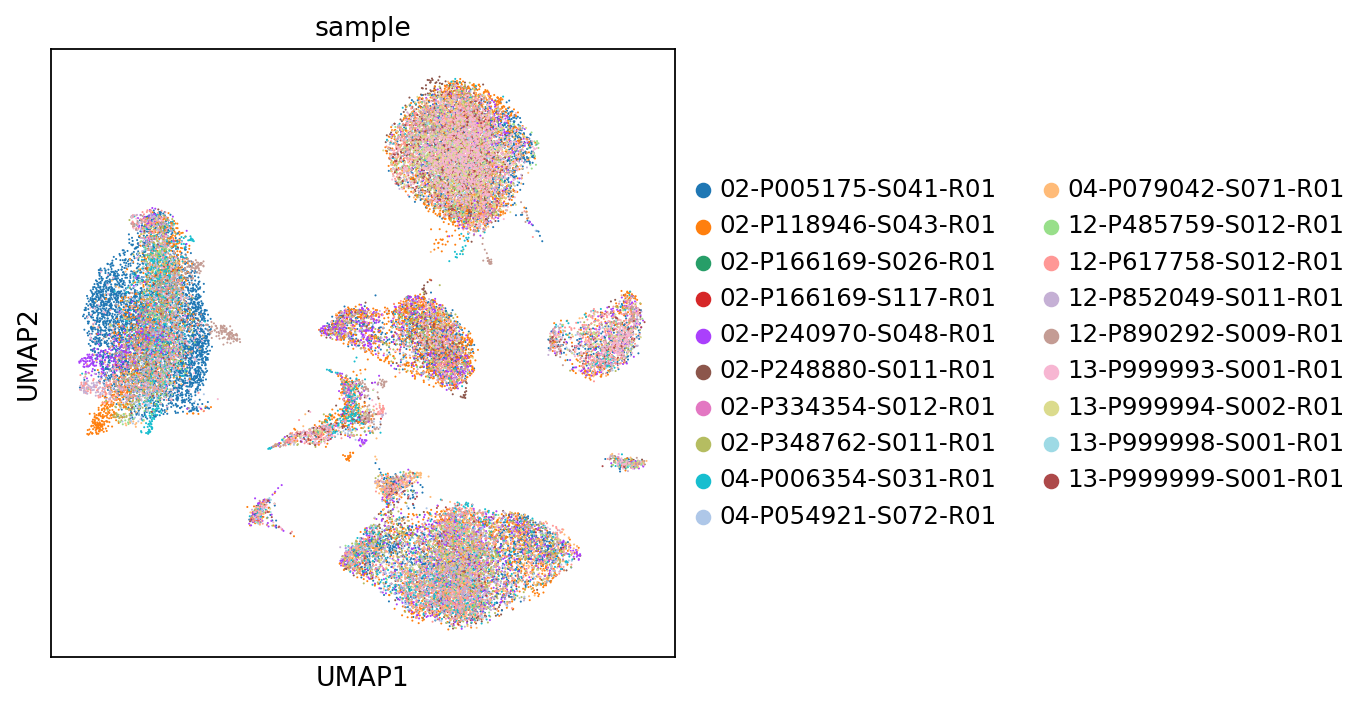

In [64]:
plt.rcParams.update({'font.size': 10})

plt.figure(figsize=(5, 5))
sc.pl.embedding(adata_clean, basis='umap', color='sample', ax=plt.gca())

In [65]:
# run clustering

res = 0.7
key = f'leiden{res}'

sc.tl.leiden(adata_clean, resolution=res, key_added=key)

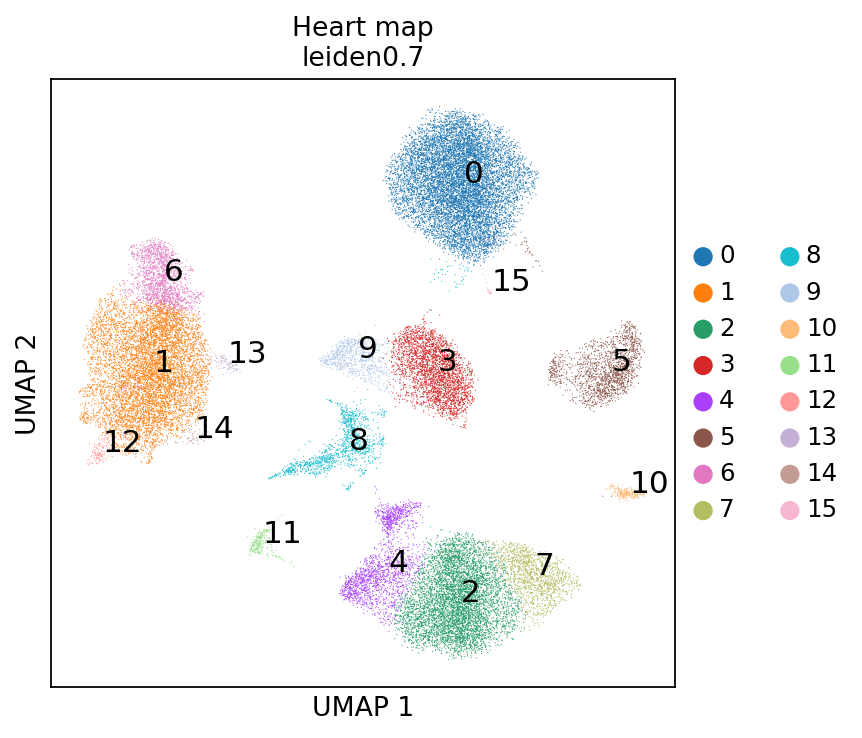

In [66]:
# umap

plt.rcParams.update({'font.size': 12})

# show clustering with numbers

key = 'leiden0.7'

plt.figure(figsize=(5, 5))
sc.pl.scatter(adata_clean, basis='umap', color=key, 
              ax=plt.gca(), size=1, show=False)

df = pd.DataFrame(adata_clean.obsm['X_umap'])
df['cluster'] = adata_clean.obs[key].values
mean_pos = df.groupby('cluster').median()

for c in mean_pos.index:
    
    plt.gca().text(mean_pos.loc[c][0] + 0.1, 
                   mean_pos.loc[c][1] + 0.01, 
                   c.split(':')[0], 
                   fontsize=14, color='black')

plt.title(f'Heart map\n{key}')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.show()

In [67]:
# cursory marker genes via wilcoxon test

key = 'leiden0.7'

sc.tl.rank_genes_groups(adata_clean, groupby=key, method='wilcoxon',
                        key_added='rank_genes_groups_' + key)  # method='t-test_overestim_var')

/home/jupyter-user/.local/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:413: RuntimeWarning: overflow encountered in expm1
  foldchanges = (expm1_func(means[imask]) + 1e-9) / (expm1_func(mean_rest) + 1e-9)  # add small value to remove 0's


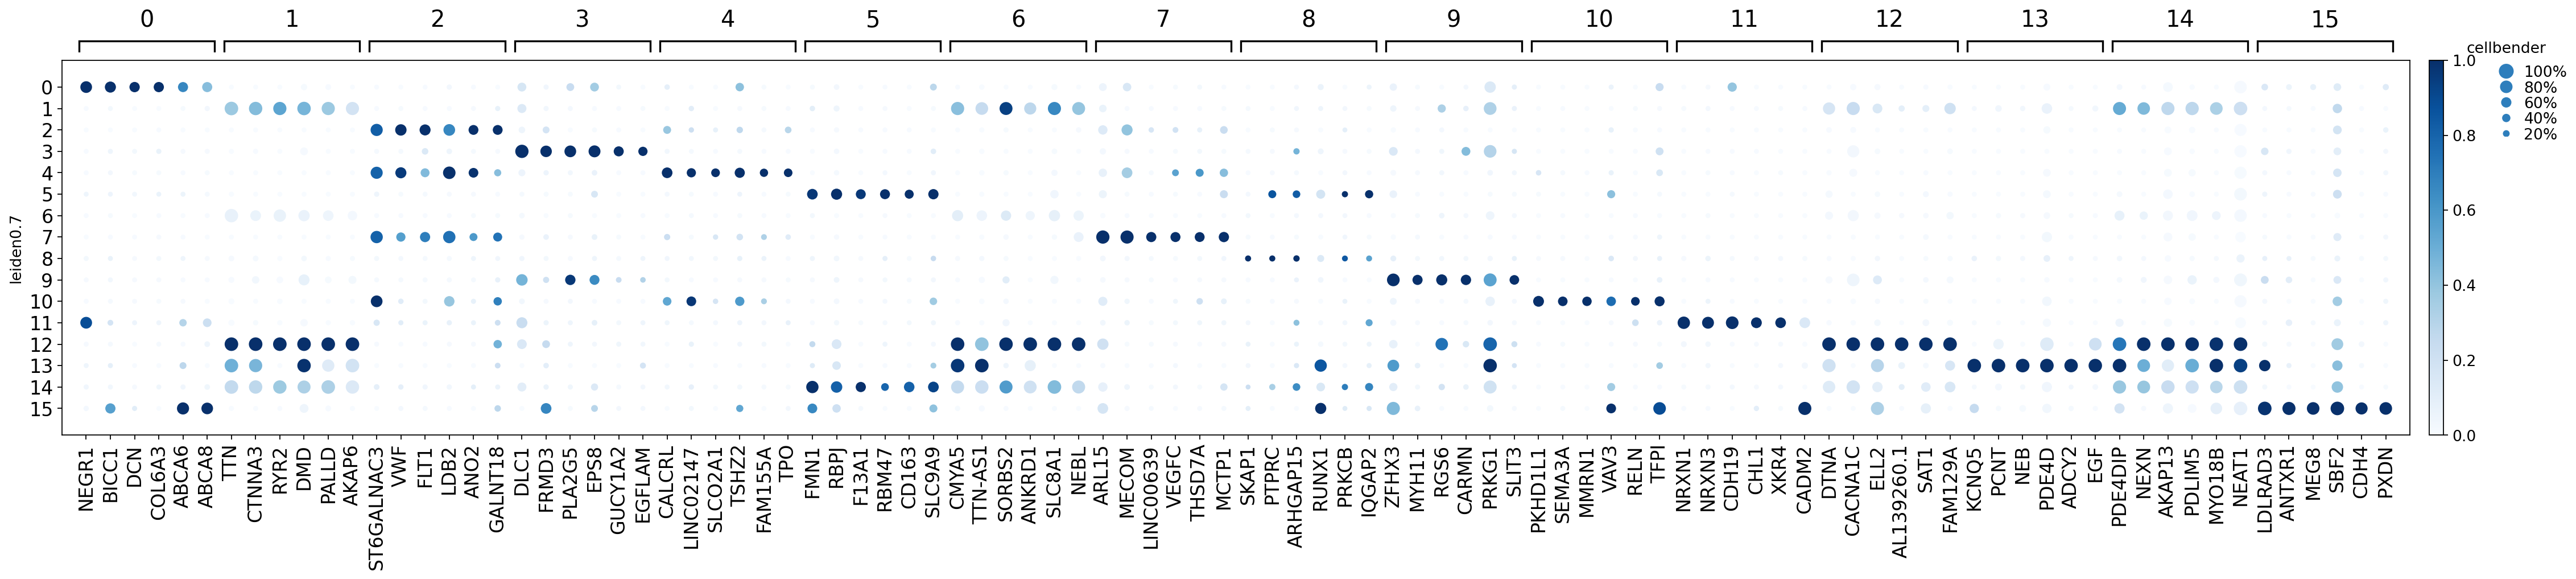

In [68]:
# plot marker genes for the outlier "clusters"
n = 6

cluster_key = key = 'leiden0.7'

marker_key = 'rank_genes_groups_' + cluster_key

marker_genes = np.array(adata_clean.uns[marker_key]['names'][:(n + 10)].tolist(), 
                        dtype=str).transpose()
unique_markers = {}
for k in range(marker_genes.shape[0]):
    i = 0
    genes = []
    for g in marker_genes[k, :]:
        if ((i < n) 
            and (g not in genes) 
            and (g not in [a for it in list(unique_markers.values()) for a in it]) 
            and (g != 'nan')):
            genes.append(g)
            i += 1
    unique_markers.update({adata_clean.obs[cluster_key].value_counts().index[k]: genes})

plt.rcParams.update({'font.size': 18})

sc.pl.dotplot(adata_clean, 
              var_names=unique_markers, 
              layer='counts',
              groupby=cluster_key,
#               log=True,
              standard_scale='var',
              color_map='Blues',
              smallest_dot=15,
              show=False)
plt.title('cellbender')
plt.show()

In [70]:
pd.crosstab(adata_clean.obs['display_sample'], adata_clean.obs['leiden0.7'])

leiden0.7          0     1    2    3    4    5    6    7    8    9  10  11  \
display_sample                                                               
D32_heart        449    32   41   58   29   63    9    5   38    7   2   7   
D31_heart        172     0   21   16    4    9    0    4    2    2   5   8   
D28_heart        771     4   70   47   15   78    5   10   34    5   4   3   
D27_heart       1198   131   64   82   34  195   29    9   60   13  20  11   
D17_heart        239   239   25   20   15   74   91   14  136   36  12   3   
D16_heart        356   249  392   96   76   96   76   48   40   14  17   5   
D15_heart        779   324  585  180  121  314   92   62  130   33   6  39   
D14_heart        177   140   89   32   18   36   45   15   19    3  21   3   
D11_heart        863   102  549   87  224   22   38  182   41   20  43  16   
D10_heart        125   467  364   51  107   28   96   51   36   12  13   3   
D8_heart          59   348  309   19   86   77  149   46  176    3   9  10   
D7_heart         968   552  835  210  213   94  140  114   43   51  13  14   
D6_heart           2     0    5    3    4    0    0    0    8    0   1   0   
D5_heart         471     1  212  131   86   44    1   33   37    8  17   6   
D4_heart         476   404  696  282  172  141   55  173  122  202  19  55   
D3_heart2         60     0   18   24   21    2    1    8    1   11   1   3   
D3_heart1          3     0    0    0    7    1    0    0   20    1   0   0   
D2_heart        1046   742  650  795  206  176  276  263  302  250  23  32   
D1_heart        1534  3481  888  755  455  267  483  413   59  151  36  40   

leiden0.7        12   13  14  15  
display_sample                    
D32_heart         0    0   0   0  
D31_heart         0    0   0   0  
D28_heart         0    0   0   0  
D27_heart         0    0   2   0  
D17_heart         0  101   1  24  
D16_heart         0    0   0   0  
D15_heart         0    0   2   0  
D14_heart         0    0   0   0  
D11_heart         0    0   0   0  
D10_heart         0    0   2   0  
D8_heart          0    0   0   0  
D7_heart          0    0   0   0  
D6_heart          0    0   0   0  
D5_heart          0    0   0   0  
D4_heart          0    0   3   0  
D3_heart2         0    0   0   0  
D3_heart1         0    0   0   0  
D2_heart        144    0   8   0  
D1_heart          0    0  47   0

In [158]:
labels = {
          '0': '0: Fibroblast',
          '1': '1: Endothelial 1',
          '2': '2: Cardiomyocyte',
          '3': '3: Cardiomyocyte',
          '4': '4: Pericyte',
          '5': '5: Endothelial 2',
          '6': '6: Endothelial 3',
          '7': '7: Macrophage',
          '8': '8: VSMC',
          '9': '9: T cell',
          '10': '10: Neuronal',
          '11': '11: Lymphatic Endothelial',
          '12': '(12): (sample-specific Cardiomyocyte/Macrophage)',}

In [159]:
adata_clean.obs['manual_labels_clean_leiden0.7'] = adata_clean.obs['leiden0.7'].apply(lambda s: labels[s])

In [34]:
adata_clean.write('/home/jupyter-user/analysis/h5ads/broad_heart_review_cleaned_annotated.h5ad')

In [12]:
adata_clean = sc.read_h5ad('/home/jupyter-user/analysis/h5ads/broad_heart_review_cleaned_annotated.h5ad')

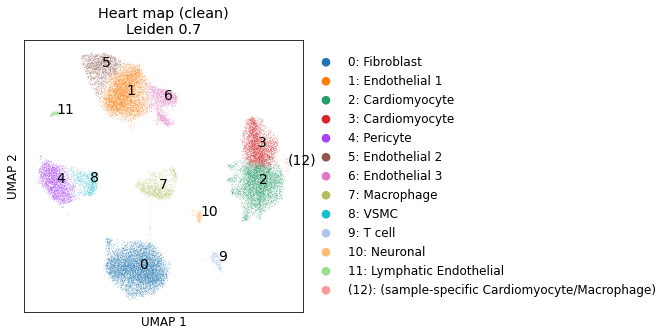

In [13]:
# umap

plt.rcParams.update({'font.size': 12})

# show clustering with numbers

key = 'manual_labels_clean_leiden0.7'

plt.figure(figsize=(5, 5))
sc.pl.scatter(adata_clean, basis='umap', color=key, 
              ax=plt.gca(), size=1, show=False)

df = pd.DataFrame(adata_clean.obsm['X_umap'])
df['cluster'] = adata_clean.obs[key].values
mean_pos = df.groupby('cluster').median()

for c in mean_pos.index:
    
    plt.gca().text(mean_pos.loc[c][0] + 0.1, 
                   mean_pos.loc[c][1] + 0.01, 
                   c.split(':')[0], 
                   fontsize=14, color='black')

plt.title(f'Heart map (clean)\nLeiden 0.7')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.show()

In [162]:
pd.crosstab(adata_clean.obs['manual_labels_leiden1.5'], adata_clean.obs['manual_labels_clean_leiden0.7'])

manual_labels_clean_leiden0.7                   0: Fibroblast  \
manual_labels_leiden1.5                                         
0: Endothelial                                              0   
1: Fibroblast                                            4458   
2: Ventricular Cardiomyocyte                                0   
3: Ventricular Cardiomyocyte                                0   
4: Fibroblast                                            2841   
5: Pericyte                                                 3   
6: Endothelial                                              0   
7: Endothelial                                              0   
8: Macrophage                                               2   
11: VSMC                                                    0   
19: Endothelial POSTN                                       0   
20: T cell                                                  0   
21: Neuronal                                                0   
22: Lymphatic Endothelial                                   0   
23: Cardiomyocyte - big                                     0   
24: Cardiomyocyte/Macrophage doublet?                       0   
25: Cardiomyocyte/Macrophage doublet? - bigger              0   

manual_labels_clean_leiden0.7                   1: Endothelial 1  \
manual_labels_leiden1.5                                            
0: Endothelial                                              5114   
1: Fibroblast                                                  0   
2: Ventricular Cardiomyocyte                                   0   
3: Ventricular Cardiomyocyte                                   0   
4: Fibroblast                                                  0   
5: Pericyte                                                    1   
6: Endothelial                                               153   
7: Endothelial                                               129   
8: Macrophage                                                 19   
11: VSMC                                                       0   
19: Endothelial POSTN                                          1   
20: T cell                                                     0   
21: Neuronal                                                   1   
22: Lymphatic Endothelial                                      0   
23: Cardiomyocyte - big                                        0   
24: Cardiomyocyte/Macrophage doublet?                          0   
25: Cardiomyocyte/Macrophage doublet? - bigger                 0   

manual_labels_clean_leiden0.7                   2: Cardiomyocyte  \
manual_labels_leiden1.5                                            
0: Endothelial                                                 0   
1: Fibroblast                                                  0   
2: Ventricular Cardiomyocyte                                4334   
3: Ventricular Cardiomyocyte                                 520   
4: Fibroblast                                                  0   
5: Pericyte                                                    0   
6: Endothelial                                                 0   
7: Endothelial                                                 0   
8: Macrophage                                                  0   
11: VSMC                                                       0   
19: Endothelial POSTN                                          0   
20: T cell                                                     0   
21: Neuronal                                                  13   
22: Lymphatic Endothelial                                      0   
23: Cardiomyocyte - big                                      204   
24: Cardiomyocyte/Macrophage doublet?                        107   
25: Cardiomyocyte/Macrophage doublet? - bigger               104   

manual_labels_clean_leiden0.7                   3: Cardiomyocyte  4: Pericyte  \
manual_labels_leiden1.5                                                         
0: Endothelial  

In [ ]:
plt.rcParams.update({'font.size': 12})

sc.pl.embedding(adata_clean, basis='umap', color=['SKAP1', 'CCL21'], 
                color_map='Oranges', vmax=5)
sc.pl.embedding(adata_clean, basis='umap', color=['HMCN1', 'DACH1'], 
                color_map='Oranges', vmax=5)
sc.pl.embedding(adata_clean, basis='umap', color=['RYR2', 'DCN'], 
                color_map='Oranges', vmax=5)

sc.pl.embedding(adata_clean, basis='umap', color=['ACE2', 'TMPRSS2'], 
                color_map='Oranges', vmax=2, size=10)
sc.pl.embedding(adata_clean, basis='umap', color=['CTSL'], 
                color_map='Oranges', vmax=2, size=10)

In [ ]:
sc.pl.embedding(adata_clean, basis='umap', color=['MARCO'], 
                color_map='Oranges', vmax=2)

## Tucker gene scores

In [12]:
adata = sc.read_h5ad('/home/jupyter-user/analysis/h5ads/graham_broad_heart_prelim_annotated.h5ad')

In [29]:
adata_clean = sc.read_h5ad('/home/jupyter-user/analysis/h5ads/graham_broad_heart_prelim_cleaned_annotated.h5ad')

In [14]:
adata_pegasus_labels = sc.read_h5ad('/home/jupyter-user/analysis/h5ads/heart_pegasus_20200716.h5ad')

In [15]:
tucker_labels = adata_pegasus_labels.obs.columns[adata_pegasus_labels.obs.columns.str.startswith('TuckerHeart_')]

In [16]:
adata_clean.obs.head(2)

barcodes  n_genes  n_counts  percent_mito  \
0-0  02-P166169-S117-R01-CTCCACAGTACAGTCT     1346    2576.0      0.582298   
1-0  02-P166169-S117-R01-TCTTGCGTCTACTTCA     1390    2105.0      0.000000   

     method               sample  doublet  max_umis  study   disease  ...  \
0-0  nuclei  02-P166169-S117-R01    False      50.0  broad  COVID-19  ...   
1-0  nuclei  02-P166169-S117-R01    False      25.0  broad  COVID-19  ...   

    TuckerHeart_Pericyte  TuckerHeart_Macrophage TuckerHeart_Endothelium.I  \
0-0             0.935813                0.752711                 -1.273673   
1-0            -0.536267               -0.460356                 -1.827615   

     TuckerHeart_Endothelium.II TuckerHeart_Adipocyte  \
0-0                   -0.390412              0.227328   
1-0                   -1.066966              0.222363   

    TuckerHeart_Vascular.Smooth.Muscle TuckerHeart_Fibroblast.III  \
0-0                          -0.520145                  -0.182410   
1-0                          -1.205999                   1.237104   

    TuckerHeart_Ventricular.Cardiomyocyte.III TuckerHeart_Neuronal  \
0-0                                 -0.192683             0.498898   
1-0                                  0.883538             0.028360   

    TuckerHeart_Lymphocyte  
0-0              -0.734609  
1-0               0.445951  

[2 rows x 38 columns]

In [17]:
adata_pegasus_labels.obs[tucker_labels].head(2)

TuckerHeart_Fibroblast.I  \
barcodekey                                                         
02-P166169-S117-R01-GTTAGACTCCTGCTAC-0                 -1.684904   
02-P166169-S117-R01-CTCCACAGTACAGTCT-0                  2.962793   

                                        TuckerHeart_Fibroblast.II  \
barcodekey                                                          
02-P166169-S117-R01-GTTAGACTCCTGCTAC-0                  -1.874910   
02-P166169-S117-R01-CTCCACAGTACAGTCT-0                   2.614348   

                                        TuckerHeart_Atrial.Cardiomyocyte  \
barcodekey                                                                 
02-P166169-S117-R01-GTTAGACTCCTGCTAC-0                         -0.551261   
02-P166169-S117-R01-CTCCACAGTACAGTCT-0                          0.700512   

                                        TuckerHeart_Ventricular.Cardiomyocyte.I  \
barcodekey                                                                        
02-P166169-S117-R01-GTTAGACTCCTGCTAC-0                                -0.240641   
02-P166169-S117-R01-CTCCACAGTACAGTCT-0                                -0.116283   

                                        TuckerHeart_Ventricular.Cardiomyocyte.II  \
barcodekey                                                                         
02-P166169-S117-R01-GTTAGACTCCTGCTAC-0                                 -0.411404   
02-P166169-S117-R01-CTCCACAGTACAGTCT-0                                 -0.105057   

                                        TuckerHeart_Pericyte  \
barcodekey                                                     
02-P166169-S117-R01-GTTAGACTCCTGCTAC-0             -1.321890   
02-P166169-S117-R01-CTCCACAGTACAGTCT-0              0.935813   

                                        TuckerHeart_Macrophage  \
barcodekey                                                       
02-P166169-S117-R01-GTTAGACTCCTGCTAC-0               -0.820876   
02-P166169-S117-R01-CTCCACAGTACAGTCT-0                0.752711   

                                        TuckerHeart_Endothelium.I  \
barcodekey                                                          
02-P166169-S117-R01-GTTAGACTCCTGCTAC-0                   2.133063   
02-P166169-S117-R01-CTCCACAGTACAGTCT-0                  -1.273673   

                                        TuckerHeart_Endothelium.II  \
barcodekey                                                           
02-P166169-S117-R01-GTTAGACTCCTGCTAC-0                    1.633845   
02-P166169-S117-R01-CTCCACAGTACAGTCT-0                   -0.390412   

                                        TuckerHeart_Adipocyte  \
barcodekey                                                      
02-P166169-S117-R01-GTTAGACTCCTGCTAC-0              -0.986488   
02-P166169-S117-R01-CTCCACAGTACAGTCT-0               0.227328   

                                        TuckerHeart_Vascular.Smooth.Muscle  \
barcodekey                                                                   
02-P166169-S117-R01-GTTAGACTCCTGCTAC-0                           -1.312261   
02-P166169-S117-R01-CTCCACAGTACAGTCT-0                           -0.520145   

                                        TuckerHeart_Fibroblast.III  \
barcodekey                                                           
02-P166169-S117-R01-GTTAGACTCCTGCTAC-0                   -0.655343   
02-P166169-S117-R01-CTCCACAGTACAGTCT-0                   -0.182410   

                                        TuckerHeart_Ventricular.Cardiomyocyte.III  \
barcodekey                                                                          
02-P166169-S117-R01-GTTAGACTCCTGCTAC-0                                   0.265463   
02-P166169-S117-R01-CTCCACAGTACAGTCT-0                                  -0.192683   

                                        TuckerHeart_Neuronal  \
barcodekey                                                     
02-P166169-S117-R01-GTTAGACTCCTGCTAC-0             -0.523385   
02-P166169-S117-R01-CTCCACAGTACAGTCT-0         

In [20]:
# add labels to adata

adata_pegasus_labels.obs = adata_pegasus_labels.obs.reset_index()
adata_pegasus_labels.obs['barcodes'] = \
    adata_pegasus_labels.obs['barcodekey'].apply(lambda s: '-'.join(s.split('-')[:-1]))

adata_pegasus_labels.obs[['barcodes'] + list(tucker_labels)].head(2)

df = pd.merge(left=adata.obs, 
              right=adata_pegasus_labels.obs[['barcodes'] + list(tucker_labels)],
              how='left', on='barcodes')

df.index = df.index.map(lambda s: str(s) + '-0')
df.head(2)

adata.obs = df.copy()

In [ ]:
# add labels to adata_clean

# adata_pegasus_labels.obs = adata_pegasus_labels.obs.reset_index()
# adata_pegasus_labels.obs['barcodes'] = \
#     adata_pegasus_labels.obs['barcodekey'].apply(lambda s: '-'.join(s.split('-')[:-1]))

# adata_pegasus_labels.obs[['barcodes'] + list(tucker_labels)].head(2)

df = pd.merge(left=adata_clean.obs, 
              right=adata_pegasus_labels.obs[['barcodes'] + list(tucker_labels)],
              how='left', on='barcodes')

df.index = df.index.map(lambda s: str(s) + '-0')
df.head(2)

adata_clean.obs = df.copy()

In [31]:
adata.obs.groupby('manual_labels_leiden1.5').median()[tucker_labels]

TuckerHeart_Fibroblast.I  \
manual_labels_leiden1.5                                                    
0: Endothelial                                                 -0.975142   
1: Fibroblast                                                   2.849211   
2: Ventricular Cardiomyocyte                                   -0.741246   
3: Ventricular Cardiomyocyte                                   -0.360192   
4: Fibroblast                                                   2.155436   
5: Pericyte                                                    -0.644694   
6: Endothelial                                                 -0.907801   
7: Endothelial                                                 -0.894626   
8: Macrophage                                                  -0.748328   
9: Low count junk?                                             -0.319310   
10: Low count junk with high mito?                             -0.464692   
11: VSMC                                                       -0.769741   
12: CM/Fibroblast doublet                                       0.046139   
13: CM/Endothelial doublet                                     -0.721685   
14: CM with high mito                                          -0.388846   
15: Fibroblast with high mito                                   0.549203   
16: Endothelial with high mito                                 -0.634404   
17: Fibroblast/Endothelial doublet                              1.667325   
18: Endothelial/Pericyte doublet                               -0.882925   
19: Endothelial POSTN                                          -0.745153   
20: T cell                                                     -0.743078   
21: Neuronal                                                    0.984267   
22: Lymphatic Endothelial                                      -0.996468   
23: Cardiomyocyte - big                                        -0.965621   
24: Cardiomyocyte/Macrophage doublet?                          -0.608213   
25: Cardiomyocyte/Macrophage doublet? - bigger                 -0.802132   

                                                TuckerHeart_Fibroblast.II  \
manual_labels_leiden1.5                                                     
0: Endothelial                                                  -0.818220   
1: Fibroblast                                                    2.340011   
2: Ventricular Cardiomyocyte                                    -0.803942   
3: Ventricular Cardiomyocyte                                    -0.422996   
4: Fibroblast                                                    1.857446   
5: Pericyte                                                     -0.359952   
6: Endothelial                                                  -0.724797   
7: Endothelial                                                  -0.728767   
8: Macrophage                                                   -0.796990   
9: Low count junk?                                              -0.328025   
10: Low count junk with high mito?                              -0.435085   
11: VSMC                                                        -0.608843   
12: CM/Fibroblast doublet                                        0.001356   
13: CM/Endothelial doublet                                      -0.640233   
14: CM with high mito                                           -0.425707   
15: Fibroblast with high mito                                    0.572849   
16: Endothelial with high mito                                  -0.478084   
17: Fibroblast/Endothelial doublet                               1.458461   
18: Endothelial/Pericyte doublet                                -0.517033   
19: Endothelial POSTN                                           -0.521967   
20: T cell                                                      -0.813928   
21: Neuronal                                                     0.652713   
22: Lymphatic Endothelial                                       -0.7807

In [33]:
adata_clean.obs.groupby('manual_labels_clean_leiden0.7').median()[tucker_labels]

TuckerHeart_Fibroblast.I  \
manual_labels_clean_leiden0.7                                                
0: Fibroblast                                                     2.594285   
1: Endothelial 1                                                 -0.967866   
2: Cardiomyocyte                                                 -0.741129   
3: Cardiomyocyte                                                 -0.338660   
4: Pericyte                                                      -0.643616   
5: Endothelial 2                                                 -0.910547   
6: Endothelial 3                                                 -0.862693   
7: Macrophage                                                    -0.745214   
8: VSMC                                                          -0.777870   
9: T cell                                                        -0.724060   
10: Neuronal                                                      1.048825   
11: Lymphatic Endothelial                                        -1.062720   
(12): (sample-specific Cardiomyocyte/Macrophage)                 -0.534704   

                                                  TuckerHeart_Fibroblast.II  \
manual_labels_clean_leiden0.7                                                 
0: Fibroblast                                                      2.180742   
1: Endothelial 1                                                  -0.811004   
2: Cardiomyocyte                                                  -0.801638   
3: Cardiomyocyte                                                  -0.381655   
4: Pericyte                                                       -0.359242   
5: Endothelial 2                                                  -0.726051   
6: Endothelial 3                                                  -0.690409   
7: Macrophage                                                     -0.799041   
8: VSMC                                                           -0.612333   
9: T cell                                                         -0.796862   
10: Neuronal                                                       0.698154   
11: Lymphatic Endothelial                                         -0.812151   
(12): (sample-specific Cardiomyocyte/Macrophage)                  -0.651357   

                                                  TuckerHeart_Atrial.Cardiomyocyte  \
manual_labels_clean_leiden0.7                                                        
0: Fibroblast                                                            -0.417052   
1: Endothelial 1                                                         -0.607045   
2: Cardiomyocyte                                                          1.057420   
3: Cardiomyocyte                                                          0.941476   
4: Pericyte                                                              -0.393596   
5: Endothelial 2                                                         -0.666605   
6: Endothelial 3                                                         -0.592484   
7: Macrophage                                                            -0.555676   
8: VSMC                                                                   0.005904   
9: T cell                                                                 0.015762   
10: Neuronal                                                             -0.470020   
11: Lymphatic Endothelial                                                -0.289424   
(12): (sample-specific Cardiomyocyte/Macrophage)                          0.678334   

                                                  TuckerHeart_Ventricular.Cardiomyocyte.I  \
manual_labels_clean_leiden0.7                                                               
0: Fibroblast                                                                   -1.071044   
1: Endothelial 1                                                                -1.000802   
2: Cardiomyocyte              

In [ ]:
# all pegasus data

plt.rcParams.update({'font.size': 12})

for key in tucker_labels:

    plt.figure(figsize=(5, 5))
    sc.pl.embedding(adata, basis='umap', color=key, color_map='Oranges', 
                    vmin=0, vmax=3,
                    ax=plt.gca(), show=False)
    plt.title(key + '\nfull map')
    plt.show()

In [ ]:
# cleaned data

plt.rcParams.update({'font.size': 12})

for key in tucker_labels:

    plt.figure(figsize=(5, 5))
    sc.pl.embedding(adata_clean, basis='umap', color=key, color_map='Oranges', 
                    vmin=0, vmax=3,
                    ax=plt.gca(), show=False)
    plt.title(key + '\ncleaned map')
    plt.show()

In [37]:
heart_labels_tucker = adata_clean.obs.columns[adata_clean.obs.columns.str.startswith('TuckerHeart_')]

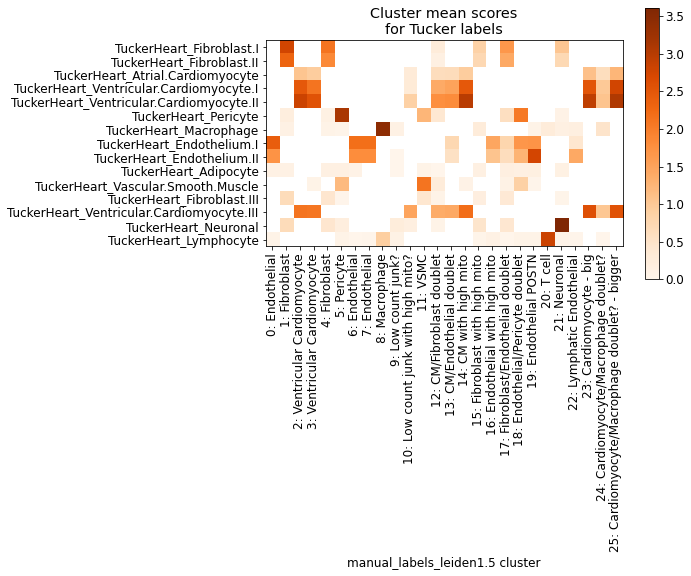

In [43]:
# make the overlap heatmap

plt.rcParams.update({'font.size': 12})

key = 'manual_labels_leiden1.5'

mat = adata.obs.groupby(key).agg(np.mean).reset_index()\
    [heart_labels_tucker].transpose().to_numpy()

mat[mat <= 0] = np.nan

plt.figure(figsize=(8, 5))

plt.imshow(mat, vmin=0, cmap='Oranges')
plt.xticks(ticks=range(adata.obs[key].value_counts().shape[0]),
           labels=adata.obs[key].value_counts().index.tolist(), rotation=90)
plt.yticks(ticks=range(len(heart_labels_tucker)), labels=heart_labels_tucker)
plt.title('Cluster mean scores\nfor Tucker labels')
plt.xlabel(key + ' cluster')
plt.colorbar()
plt.show()

In [38]:
adata_clean.obs.groupby('leiden0.7').agg(np.median).reset_index()[heart_labels_tucker].transpose()

0         1         2  \
TuckerHeart_Fibroblast.I                   2.594285 -0.967866 -0.741129   
TuckerHeart_Fibroblast.II                  2.180742 -0.811004 -0.801638   
TuckerHeart_Atrial.Cardiomyocyte          -0.417052 -0.607045  1.057420   
TuckerHeart_Ventricular.Cardiomyocyte.I   -1.071044 -1.000802  2.396767   
TuckerHeart_Ventricular.Cardiomyocyte.II  -1.318107 -1.382567  2.773639   
TuckerHeart_Pericyte                       0.137863 -0.440980 -0.943513   
TuckerHeart_Macrophage                     0.064127 -0.350424 -0.410718   
TuckerHeart_Endothelium.I                 -1.015039  2.447268 -1.313882   
TuckerHeart_Endothelium.II                -0.662337  1.742712 -1.322402   
TuckerHeart_Adipocyte                      0.079212  0.073566 -0.172590   
TuckerHeart_Vascular.Smooth.Muscle        -0.047222 -0.473634 -0.035509   
TuckerHeart_Fibroblast.III                 0.533370 -0.296456 -0.296134   
TuckerHeart_Ventricular.Cardiomyocyte.III -1.024866 -0.966478  2.063836   
TuckerHeart_Neuronal                       0.567437 -0.354553 -0.414452   
TuckerHeart_Lymphocyte                    -0.158857 -0.016839 -0.217699   

                                                  3         4         5  \
TuckerHeart_Fibroblast.I                  -0.338660 -0.643616 -0.910547   
TuckerHeart_Fibroblast.II                 -0.381655 -0.359242 -0.726051   
TuckerHeart_Atrial.Cardiomyocyte           0.941476 -0.393596 -0.666605   
TuckerHeart_Ventricular.Cardiomyocyte.I    2.102191 -1.307794 -0.950471   
TuckerHeart_Ventricular.Cardiomyocyte.II   2.563053 -1.358804 -1.348177   
TuckerHeart_Pericyte                      -0.590119  3.195131 -0.397917   
TuckerHeart_Macrophage                    -0.321509  0.012617 -0.258375   
TuckerHeart_Endothelium.I                 -0.836277 -0.783875  2.187022   
TuckerHeart_Endothelium.II                -0.811915 -0.556136  1.797137   
TuckerHeart_Adipocyte                     -0.215175  0.113237  0.042607   
TuckerHeart_Vascular.Smooth.Muscle         0.050177  1.194169 -0.450846   
TuckerHeart_Fibroblast.III                -0.161509 -0.050527 -0.322160   
TuckerHeart_Ventricular.Cardiomyocyte.III  2.108217 -1.209044 -1.127231   
TuckerHeart_Neuronal                      -0.218772  0.208850 -0.338807   
TuckerHeart_Lymphocyte                    -0.133586 -0.063661 -0.084317   

                                                  6         7         8  \
TuckerHeart_Fibroblast.I                  -0.862693 -0.745214 -0.777870   
TuckerHeart_Fibroblast.II                 -0.690409 -0.799041 -0.612333   
TuckerHeart_Atrial.Cardiomyocyte          -0.592484 -0.555676  0.005904   
TuckerHeart_Ventricular.Cardiomyocyte.I   -1.021126 -0.892393 -0.502380   
TuckerHeart_Ventricular.Cardiomyocyte.II  -1.443253 -0.900430 -0.532357   
TuckerHeart_Pericyte                      -0.417698 -0.558024  1.018658   
TuckerHeart_Macrophage                    -0.133182  3.699263 -0.236497   
TuckerHeart_Endothelium.I                  2.094732 -0.714955 -0.752868   
TuckerHeart_Endothelium.II                 2.011796 -0.425926 -0.436316   
TuckerHeart_Adipocyte                     -0.043276 -0.356939  0.063941   
TuckerHeart_Vascular.Smooth.Muscle        -0.370962 -0.500555  2.118613   
TuckerHeart_Fibroblast.III                -0.161467 -0.151310  0.327227   
TuckerHeart_Ventricular.Cardiomyocyte.III -1.159711 -0.935506 -0.164853   
TuckerHeart_Neuronal                      -0.336332 -0.268108 -0.175939   
TuckerHeart_Lymphocyte                    -0.058442  0.905305 -0.139843   

                                                  9        10        11  \
TuckerHeart_Fibroblast.I                  -0.724060  1.048825 -1.062720   
TuckerHeart_Fibroblast.II                 -0.796862  0.698154 -0.812151   
TuckerHeart_Atrial.Cardiomyocyte           0.015762 -0.470020 -0.289424   
TuckerHeart_Ventricular.Cardiomyocyte.I   -0.969224 -0.530179 -0.788656   
TuckerHeart_Ventricular.Cardiomyocyte.II  -0.881284 -0.616290 -0.897065 

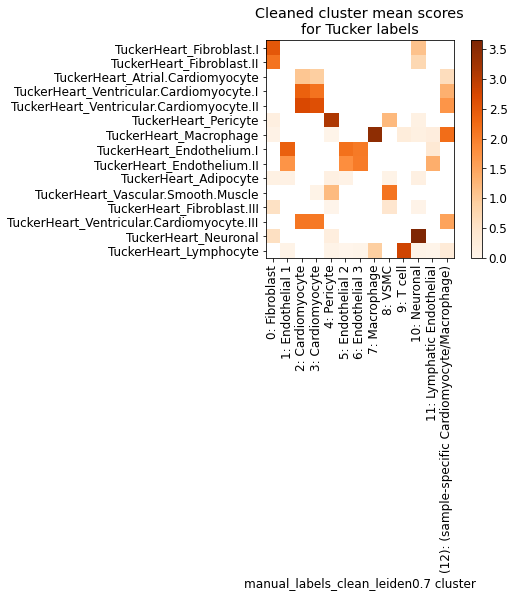

In [44]:
# make the overlap heatmap

plt.rcParams.update({'font.size': 12})

key = 'manual_labels_clean_leiden0.7'

mat = adata_clean.obs.groupby(key).agg(np.mean).reset_index()\
    [heart_labels_tucker].transpose().to_numpy()

mat[mat <= 0] = np.nan

plt.imshow(mat, vmin=0, cmap='Oranges')
plt.xticks(ticks=range(adata_clean.obs[key].value_counts().shape[0]),
           labels=adata_clean.obs[key].value_counts().index.tolist(), rotation=90)
plt.yticks(ticks=range(len(heart_labels_tucker)), labels=heart_labels_tucker)
plt.title('Cleaned cluster mean scores\nfor Tucker labels')
plt.xlabel(key + ' cluster')
plt.colorbar()
plt.show()

In [236]:
adata.shape

(36662, 30015)

In [237]:
adata_clean.shape

(30331, 30015)

In [238]:
adata_clean.write('/home/jupyter-user/analysis/h5ads/graham_broad_heart_prelim_cleaned_annotated.h5ad')

## Viral reads

In [239]:
adata.var_names

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2ML1-AS1',
       'A3GALT2', 'A4GALT', 'A4GNT',
       ...
       'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B',
       'ZYX', 'ZZEF1'],
      dtype='object', name='featurekey', length=30015)

In [240]:
adata.var_names[adata.var_names.str.startswith('SARS')]

Index(['SARS', 'SARS2'], dtype='object', name='featurekey')

These are not viral genes.  There are no viral reads.

## Adata cleanup and documentation for others

### All cells

In [5]:
# adata_clean = sc.read_h5ad('/home/jupyter-user/analysis/h5ads/graham_broad_heart_prelim_cleaned_annotated.h5ad')

In [241]:
# adata

In [242]:
# adata.var.head()

In [243]:
# adata.uns['README'] = \
# '=== README ===\n\n'\
# 'Heart data from the Regev Covid19 study.  nuclear scRNA-seq, 3primeV3 chemistry from 10x Genomics. \n\n'\
# 'This is an adata object produced mainly by Pegasus, and so there are lots and lots of different annotations '\
# 'that have been automatically generated.  Many of the columns in adata.obs are gene-set-scores.  Many of the '\
# 'relevant ones begin with "TuckerHeart_".  Sample names are contained in adata.obs["Channel"].  I do not know '\
# 'what all the columns in adata.var are.  Gene symbols can '\
# 'be accessed using adata.var_names, and Ensembl gene IDs can be accessed using adata.var["featureid-0"] \n\n'\
# 'This map has been produced by first taking as "highly variable genes" those genes which are highly-variable in '\
# 'at least 4 samples.  PCA was then performed using those genes, to obtain 50 PCs.  Harmony-pytorch was used to '\
# 'batch-correct those PCs by sample.  UMAP was performed using those 50 batch-corrected PCs to make a map. \n\n'\
# 'Clustering was performed on all the cells using the Leiden algorithm with resolution 1.0 to over-cluster the map. '\
# 'A Wilcoxon test was performed to look at marker genes.  That information is in '\
# 'adata.uns["rank_genes_groups_leiden1.0"].  Based on these markers, it was determined that Leiden1.0 clusters '\
# '[8, 10, 12, 14] are mitochondrial junk, and that [13, 17, 18] are doublets. \n\n'\
# 'A second adata file (not this one) contains only the "clean" data, with those nuclei removed.'

In [244]:
# print(adata.uns['README'])

In [245]:
# adata.write('/home/jupyter-user/analysis/h5ads/regev_covid_heart_pegasus_all_nuclei.h5ad')

### QCed cells only

In [246]:
# adata_clean = sc.read_h5ad('/home/jupyter-user/analysis/h5ads/heart_pegasus_clean_20200716.h5ad')

In [247]:
# adata_clean

In [248]:
# adata_clean.uns['README'] = \
# '=== README ===\n\n'\
# 'Heart data from the Regev Covid19 study.  nuclear scRNA-seq, 3primeV3 chemistry from 10x Genomics. \n\n'\
# 'This is an adata object produced mainly by Pegasus, and so there are lots and lots of different annotations '\
# 'that have been automatically generated.  Many of the columns in adata.obs are gene-set-scores.  Many of the '\
# 'relevant ones begin with "TuckerHeart_".  Sample names are contained in adata.obs["Channel"].  I do not know '\
# 'what all the columns in adata.var are.  Gene symbols can '\
# 'be accessed using adata.var_names, and Ensembl gene IDs can be accessed using adata.var["featureid-0"] \n\n'\
# 'This adata object contains a subset of the cells that passed additional QC.\n\n'\
# 'This map has been produced by first taking as "highly variable genes" those genes which are highly-variable in '\
# 'at least 4 samples.  PCA was then performed using those genes, to obtain 50 PCs.  Harmony-pytorch was used to '\
# 'batch-correct those PCs by sample.  UMAP was performed using those 50 batch-corrected PCs to make a map. \n\n'\
# 'Clustering was performed on all the cells using the Leiden algorithm with resolution 0.7 (adata.obs["leiden0.7"]) '\
# 'and a Wilcoxon test was performed to identify marker genes (adata.uns["rank_genes_groups_leiden0.7"]).  '\
# 'Based on these marker genes, the clusters were manually annotated with cell-type labels, and that information is '\
# 'in adata.obs["labels"].'

In [249]:
# print(adata_clean.uns['README'])

In [250]:
# adata_clean.obs['labels'].value_counts()

In [251]:
# adata_clean.write('/home/jupyter-user/analysis/h5ads/regev_covid_heart_pegasus_nuclei_subset_annotated.h5ad')

In [252]:
# !ls -lh /home/jupyter-user/analysis/h5ads/

In [253]:
!gsutil cp /home/jupyter-user/analysis/h5ads/graham_broad_heart*.h5ad gs://fc-7e30ec48-0a0c-484f-a784-b6c7f44dd2c7/notebooks

Copying file:///home/jupyter-user/analysis/h5ads/graham_broad_heart_prelim.h5ad [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file:///home/jupyter-user/analysis/h5ads/graham_broad_heart_prelim_annotated.h5ad [Content-Type=application/octet-stream]...
Copying file:///home/jupyter-user/analysis/h5ads/graham_br